## Dissertation Project

## Hotel Demand Forecasting Model - Luton

In this notebook, we build a time series model that predicts future hotel occupancy based on historical booking data from the Luton Branch of the Hotel Franchise. The notebook contains 6 sections that introduce the problem, prepare the data, build and test several models and finally highlight the results. <br>

We begin by understanding the problem and studying the data.
 

## 1. Problem Understanding and Data Preparation 
The hospitality industry is dynamic and very responsive to the global economic environment. It is characterized by increasing room supply and high cost margins. The stiff competition makes it imperative for hotel revenue managers to constantly adjust pricing in order for their strategies to remain relevant. Hotel’s typically have a high fixed cost and therefore, the ability to manage variable costs becomes a crucial determinant of overall profitability. An accurate forecast is important for hotel management to be able to properly staff and purchase supplies. Overstaffing or over ordering creates excessive costs for the occupancy and revenue. Understaffing or under ordering can create guest service problems and or run out of necessary operating supplies. Profitability and guest service in lodging are optimized when these workers match resources with the number of occupied rooms. In this project, we are working with a major hotel chain to build a demand forecasting system that will help them improve their operational efficiency and optimize their pricing strategy.  <br>

This section contains codes that carry out the following tasks-
<li> Importing the packages required for the analysis</li>
<li> Importing the relevant datsets</li>
<li> Cleaning and structuring the datasets</li>

In [152]:
!pip install pyramid-arima
!pip install keras

In [153]:
# importing the required packages 
import sherlockml.datasets as sfs
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, classification_report, roc_curve, auc

#View all columns of dataframes
pd.options.display.max_columns = None

#ignore warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)

import IPython
from IPython import display

-------------------------


In [154]:
#Load the main Dataset
ltn=pd.read_csv('ltnap_history.csv')
ltn.columns = ['S.no','Rs_Date', 'Rs_Reserid','Rs_Arrdate','Rs_Depdate','Rs_Rooms','Rs_Ratecod','Rs_Rate','Rs_Ratesum','Rs_Market','Rs_Created','Holidex','Rs_lead']

# Keep a copy of original data in case of changes made to dataframe
ltn_copy = ltn.copy()

#Check dataset contents
ltn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89418 entries, 0 to 89417
Data columns (total 13 columns):
S.no          89418 non-null int64
Rs_Date       89418 non-null object
Rs_Reserid    89418 non-null int64
Rs_Arrdate    89418 non-null object
Rs_Depdate    89418 non-null object
Rs_Rooms      89418 non-null int64
Rs_Ratecod    89406 non-null object
Rs_Rate       89418 non-null float64
Rs_Ratesum    89418 non-null float64
Rs_Market     89408 non-null object
Rs_Created    89418 non-null object
Holidex       89418 non-null object
Rs_lead       89418 non-null int64
dtypes: float64(2), int64(4), object(7)
memory usage: 8.9+ MB


## Data Preparation
Based on the business rules used by the hotel chain with respect to capturing the booking data: 
- The rows where the Rs_Rooms column is '0' means the booking was cancelled with a full refund 
- The rows where Rs_Rate is less than '30' means it was a complimentary booking made for staff and is not considered as a 'guest booking'
- The maximum price charged for a room is 220 and bookings that have an Rs_Rate higher than this implies the customer was charged for damages or additional services and should not be considered

We start by filtering out these records.

In [155]:
#filtering data based on business rules
ltn=ltn[ltn.Rs_Rooms!=0] 
ltn=ltn[ltn.Rs_Rate > 30]
ltn=ltn[ltn.Rs_Rate < 220]

In [156]:
#Adding a column for booking lead time(days in advance a booking was made)
ltn['Rs_Date'] = pd.to_datetime(ltn['Rs_Date'])
ltn['Rs_Created'] = pd.to_datetime(ltn['Rs_Created'])
ltn['Rs_Arrdate'] = pd.to_datetime(ltn['Rs_Arrdate'])
ltn['Rs_Depdate'] = pd.to_datetime(ltn['Rs_Depdate'])
ltn.head() 

,S.no,Rs_Date,Rs_Reserid,Rs_Arrdate,Rs_Depdate,Rs_Rooms,Rs_Ratecod,Rs_Rate,Rs_Ratesum,Rs_Market,Rs_Created,Holidex,Rs_lead
0,1,2017-01-01,85639553,2017-01-01,2017-02-01,1,IDOTHHE4,49.00,57.00,A1,2016-12-20,LTNAP,12
1,2,2017-01-01,85624652,2017-01-01,2017-02-01,1,IDOTHHE4,49.00,57.00,A1,2016-09-08,LTNAP,145
2,3,2017-01-01,85612823,2017-01-01,2017-02-01,1,IDH0G,69.00,77.00,A2,2016-05-05,LTNAP,241
3,4,2017-01-01,85634244,2017-01-01,2017-02-01,1,IDU0G,75.99,83.99,B3,2016-10-28,LTNAP,65
4,5,2017-01-01,85640388,2017-01-01,2017-02-01,1,IGCOR,75.99,83.99,B3,2017-01-01,LTNAP,0


The next step is to convert the data into a time series format that will later be used for modelling

In [157]:
# Keep only the required columns to create a time series dataset for bookings per night
ltn_1 = ltn[['Rs_Date','Rs_Reserid']].drop_duplicates()

#Finding Bookings per day
ltn_bookings=ltn_1.groupby(['Rs_Date']).count()

#reseting index
ltn_bookings.reset_index(level=0, inplace=True)

#converting RS date to datetime format
ltn_bookings['Rs_Date'] = pd.to_datetime(ltn_bookings['Rs_Date'])
ltn_bookings.columns = ['Rs_Date', 'Rs_Reserid']

ltn_bookings=ltn_bookings.sort_values(by=['Rs_Date'])
ltn_bookings.head()

,Rs_Date,Rs_Reserid
0,2017-01-01,60
1,2017-01-02,114
2,2017-01-03,153
3,2017-01-04,117
4,2017-01-05,132


## 2. Exploratory Data Analysis

<br>
Using the historical Booking data from the Luton hotel, we conducted an empirical study to forecast future hotel room demand. The data set was provided by Satalia Inc. and included daily room nights sold (occupancy) for the period between January 2016 and December 2018. Each row in the dataset represents a single room booking for a given date and includes other information like the booking ID, check-in date, check-out date and price of the room for that particular night. The data dictionary below describes each of the ten variables that were present in the dataset. The data set was divided into two segments: the training (i.e. historical data that explain observation already obtained) and the validation (i.e. variable values yet to be realized), in order to train and evaluate the model’s forecasting performance.

The aim is to predict the future demand for a hotel room on a particular day for a time period of 3 months (90 days) into the future. The output from the model will be the number of rooms that are most likely to be booked for each of the next 90 days. The forecast model is built to be retrained everyday based on the latest booking information. Each row in the dataset represents a single room being booked for a given date and includes other information like the booking ID, check-in date, check-out date and price of the room for that particular night. 

In [232]:
print(plt.style.available)

['fast', 'seaborn-paper', 'seaborn-poster', 'dark_background', 'seaborn-deep', 'ggplot', 'seaborn-whitegrid', 'seaborn-colorblind', 'seaborn-darkgrid', 'seaborn-pastel', 'grayscale', 'seaborn-talk', '_classic_test', 'seaborn-white', 'classic', 'seaborn-muted', 'seaborn', 'bmh', 'seaborn-dark-palette', 'seaborn-notebook', 'seaborn-ticks', 'Solarize_Light2', 'tableau-colorblind10', 'seaborn-dark', 'fivethirtyeight', 'seaborn-bright']


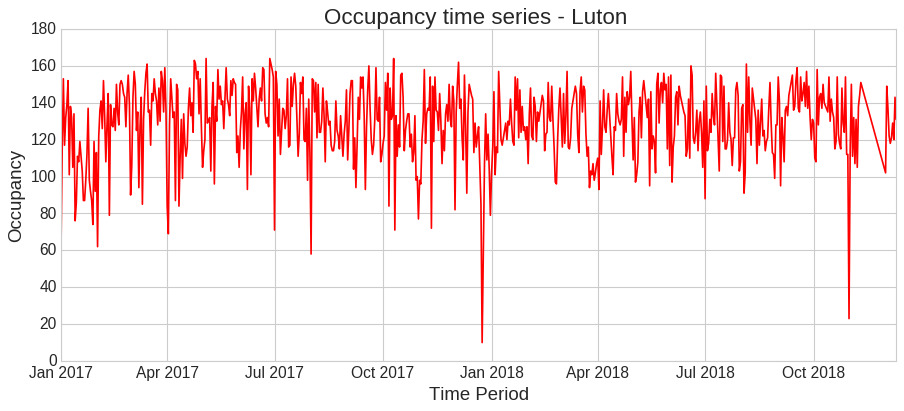

In [12]:
#viewing the booking trends for the Bristol hotel over the last 2 years
import matplotlib
matplotlib.rc('figure', figsize=(12, 5))
plt.style.use('seaborn-whitegrid')
plt.plot(ltn_bookings.Rs_Date, ltn_bookings.Rs_Reserid, label='Actual',lw=1.5, color='red')

# Add title and axis names
plt.title('Occupancy time series - Luton ')
plt.xlabel('Time Period')
plt.ylabel('Occupancy')
plt.show()

An initial observation about the aggregated booking data series is that it does not show a trend,cycle or seasonality over the 2 year time period. 

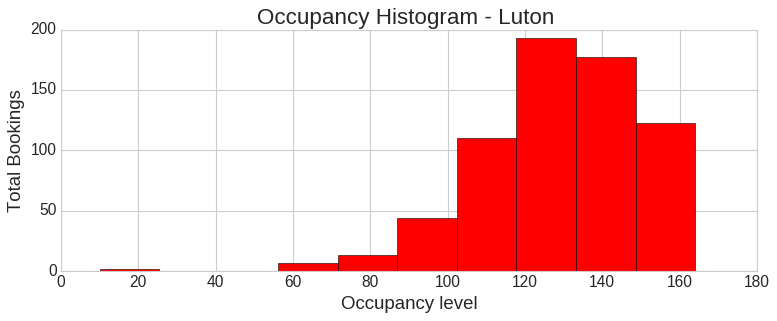

In [13]:
# plotting a histogram for occupancylevels
plt.figure(3,figsize=(10, 8))
plt.subplot(211)
ltn_bookings.Rs_Reserid.hist(color='red')
# Add title and axis names
plt.title('Occupancy Histogram - Luton ')
plt.xlabel('Occupancy level')
plt.ylabel('Total Bookings')
plt.show(3)

In [13]:
ltn_bookings.Rs_Reserid.describe()

count    669.000000
mean     128.751868
std       20.502914
min       10.000000
25%      117.000000
50%      131.000000
75%      144.000000
max      164.000000
Name: Rs_Reserid, dtype: float64

We observe that the mean occupancy is ~128 per night. The max occupancy is 164 rooms and therefore present occupancy is 77% on an average. The lowest bookings for a night is 11 but the hotel shows a relatively high occupancy rate in general.

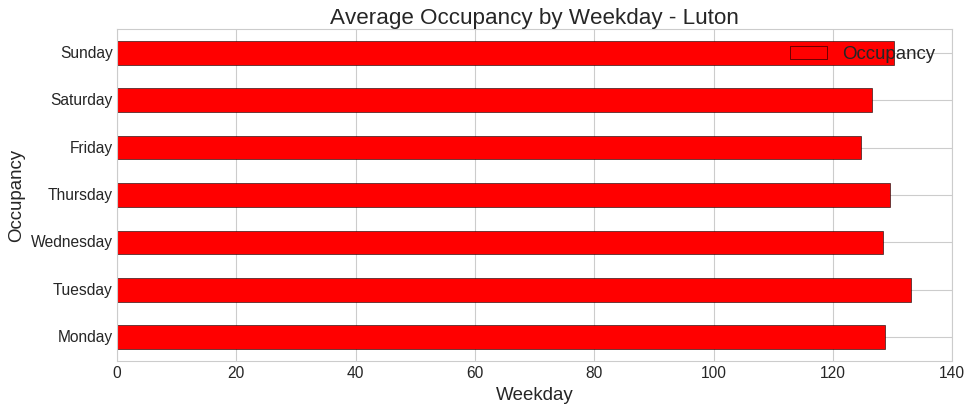

,Occupancy
Rs_Date,
Monday,128.697917
Tuesday,133.177083
Wednesday,128.400000
Thursday,129.617021
Friday,124.673684
Saturday,126.494845
Sunday,130.197917


In [30]:
#Finding Average bookings per day of week
week_booking = ltn_bookings.groupby(ltn_bookings['Rs_Date'].dt.weekday_name).mean()
week_booking=week_booking.reindex(["Monday", "Tuesday", "Wednesday","Thursday","Friday","Saturday","Sunday"])
week_booking.columns=['Occupancy']
week_booking.plot(kind='barh',color='red',label='occupancy',title='Average Occupancy by Weekday - Luton')
plt.xlabel('Weekday')
plt.ylabel('Occupancy')
plt.show()
week_booking

We observe that Tuesday has the highest number of daily bookings with ~133 on an average while Friday has the lowest (124). Overall, the booking fluctuation among weekdays isn't significant but still can be used as a feature in our model. 

Next we observe the booking trends by month-

In [15]:
#aggregating data at a month level
month_booking = ltn_bookings.groupby(ltn_bookings['Rs_Date'].dt.strftime('%B')).mean()
month_booking=month_booking.sort_values(by=['Rs_Date'])
month_booking=month_booking.reindex(["January", "February", "March","April","May","June","July","August","September","October","November","December"])
month_booking.columns=['Occupancy']
month_booking

,Occupancy
Rs_Date,
January,118.333333
February,130.666667
March,130.333333
April,129.362069
May,133.616667
June,134.000000
July,129.800000
August,126.950000
September,134.120690


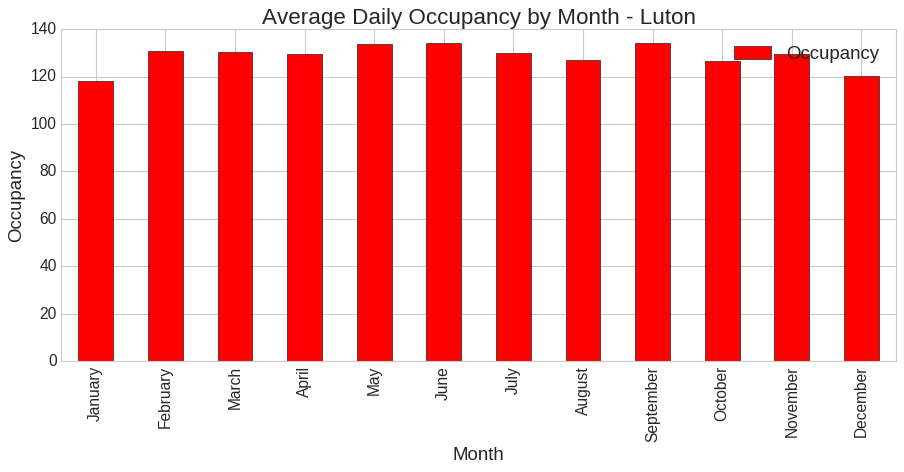

In [32]:
#plotting monthly booking bar chart
month_booking.plot(kind='bar',color='red',title='Average Daily Occupancy by Month - Luton')
plt.xlabel('Month')
plt.ylabel('Occupancy')
plt.show()

We observe that January(118) has the least bookings while September(134) has the most average bookings. Overall, there isn't any real seasonality in the daily bookings among months as the range is quite small.Next we invetigate the booking trends by market segment .

Next we invetigate the booking trends by market segment . The priliminary assumption is that each segments bookings are correlated with overall booking for a time period. We start by checking the number of bookings per segment-

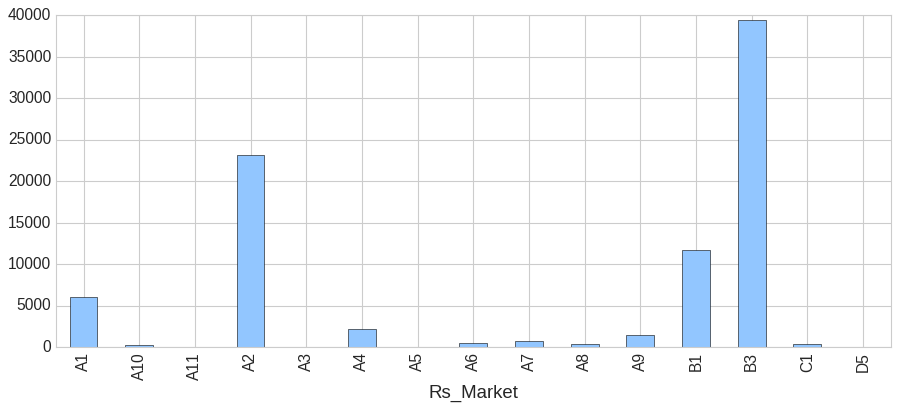

In [33]:
#checking booking by market segement
ltn_mkt = ltn[['Rs_Date','Rs_Reserid','Rs_Market']].drop_duplicates()
ltn_mkt.columns=['Rs_Date','Rs_Reserid','Rs_Market']
ltn_mkt['Rs_Date'] = pd.to_datetime(ltn_mkt['Rs_Date'])
ltn_mkt.Rs_Date = ltn_mkt.Rs_Date.astype(str)
ltn_mkt_sum = ltn_mkt.groupby(['Rs_Market']).count()
ltn_mkt=ltn_mkt.groupby(['Rs_Date','Rs_Market']).count()

ltn_mkt_sum.Rs_Reserid.plot(kind='bar')
plt.show()

We observe that the Wholesale rates (A1) Advance Bookings(A2), Corporate/Travel(B1) and Best Flexible rate (B3) segments make up for majority (89%) of the total bookings received by the hotels.
<br>

We will now check the correlation between booking by segment and overall bookings-

In [34]:
#merging overall daily booking with bookings by segment
ltn_mkt= ltn_mkt.pivot_table(index=['Rs_Date'], columns=['Rs_Market'],values='Rs_Reserid', aggfunc='first', fill_value=0)

ltn_bookings_1=ltn_bookings
ltn_bookings_1.columns=['Rs_Date','Rs_Reserid']
ltn_bookings_1.Rs_Date = ltn_bookings_1.Rs_Date.astype(str)
ltn_bookings_1=ltn_bookings_1.set_index('Rs_Date')
df_merged = pd.merge(ltn_bookings_1, ltn_mkt,left_index=True,right_index=True, how='left')

In [35]:
df_merged.corr()

,Rs_Reserid,A1,A10,A11,A2,A3,A4,A5,A6,A7,A8,A9,B1,B3,C1,D5
Rs_Reserid,1.000000,0.193109,0.068381,-0.014475,0.187548,0.050109,0.171122,0.017974,0.037787,0.135570,0.158798,0.117438,0.325141,0.524623,0.129418,-0.032816
A1,0.193109,1.000000,-0.054775,-0.017511,0.037523,-0.042606,0.000726,0.011853,0.095575,-0.020673,0.098702,-0.110145,0.019723,-0.161644,0.011447,-0.001848
A10,0.068381,-0.054775,1.000000,-0.011211,0.031688,-0.009147,-0.019733,-0.005047,-0.073580,0.030870,-0.091096,-0.066134,-0.007386,-0.036583,0.014213,-0.026973
A11,-0.014475,-0.017511,-0.011211,1.000000,0.021504,-0.003675,0.045648,-0.005205,-0.022362,0.009357,0.031694,-0.012749,-0.012429,-0.024193,-0.010378,-0.010837
A2,0.187548,0.037523,0.031688,0.021504,1.000000,-0.034148,0.056730,-0.042645,-0.012392,0.036139,0.034940,-0.146332,-0.406126,-0.370454,-0.015102,-0.035128
A3,0.050109,-0.042606,-0.009147,-0.003675,-0.034148,1.000000,0.032872,-0.004247,-0.035935,-0.005985,-0.032193,-0.026538,0.014636,0.097410,-0.026451,-0.008842
A4,0.171122,0.000726,-0.019733,0.045648,0.056730,0.032872,1.000000,-0.027735,0.018924,0.019674,-0.042125,0.051612,-0.183624,0.165851,-0.014740,0.090110
A5,0.017974,0.011853,-0.005047,-0.005205,-0.042645,-0.004247,-0.027735,1.000000,-0.050896,0.034925,-0.025041,-0.020446,0.127291,-0.045256,0.038949,-0.012523
A6,0.037787,0.095575,-0.073580,-0.022362,-0.012392,-0.035935,0.018924,-0.050896,1.000000,-0.030653,0.217750,0.229130,-0.178315,0.056298,-0.057232,0.013705
A7,0.135570,-0.020673,0.030870,0.009357,0.036139,-0.005985,0.019674,0.034925,-0.030653,1.000000,-0.000410,0.003969,-0.018641,0.056145,0.090054,0.024874


Surprisingly, we observe that there is no real correlation between the segment bookings and the overall bookings. Further, we can classify the market segments into 4 groups to simplify the classification - Advance Bookings(A2), Corporate/Travel(B1), Best Flexible rate (B3) and Others (All other segments) <br> 

Going forward we could consider making individual forecasts for each of these groups and adding them up to have the most accurate final forecast numbers. This is because the overall booking paaterns and market segment specific patterns follow different trends.

In [36]:
#Creating a table for 4 new segments
ltn_seg_final = ltn[['Rs_Date','Rs_Reserid','Rs_Market']].drop_duplicates()
ltn_seg_final['Rs_Market'].replace(['A3','A4','A5','A6','A7','A8','A9','A10','A11','B2','C1','D5','A1'],['Other','Other','Other','Other','Other','Other','Other','Other','Other','Other','Other','Other','Other'],inplace=True)
ltn_seg_final.columns=['Rs_Date','Rs_Reserid','Rs_Market']
ltn_seg_final['Rs_Date'] = pd.to_datetime(ltn_seg_final['Rs_Date'])
ltn_seg_final1=ltn_seg_final.groupby(['Rs_Date','Rs_Market']).count()
ltn_seg_final1= ltn_seg_final1.pivot_table(index=['Rs_Date'], columns=['Rs_Market'],values='Rs_Reserid', aggfunc='first', fill_value=0)
ltn_seg_final1.head()

# finding correlation between the 4 segments
df_merge_final = pd.merge(ltn_bookings_1, ltn_seg_final1,left_index=True,right_index=True, how='left')
df_merge_final.columns=['Overall','A2','B1','B3','Other']
df_merge_final.corr()

,Overall,A2,B1,B3,Other
Overall,1.000000,0.187548,0.325141,0.524623,0.325966
A2,0.187548,1.000000,-0.406126,-0.370454,-0.020958
B1,0.325141,-0.406126,1.000000,-0.060530,-0.052184
B3,0.524623,-0.370454,-0.060530,1.000000,-0.042488
Other,0.325966,-0.020958,-0.052184,-0.042488,1.000000


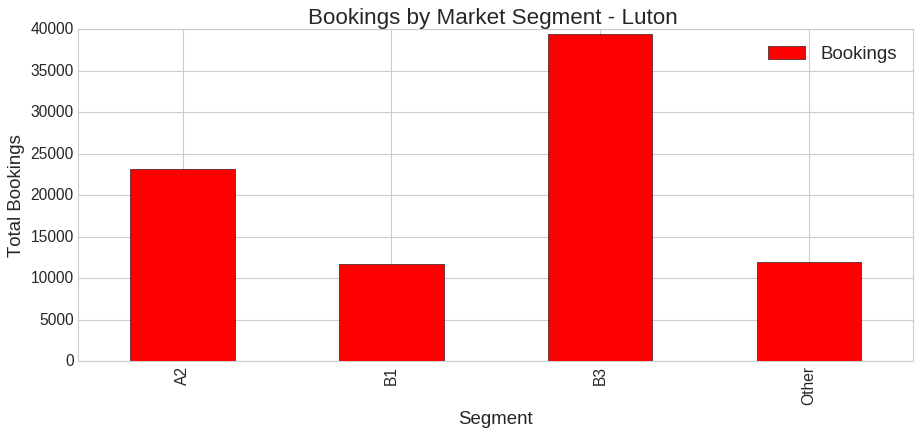

,Bookings
Rs_Market,
A2,23127
B1,11683
B3,39426
Other,11889


In [37]:
ltn_seg_final2=ltn_seg_final[['Rs_Market','Rs_Reserid']]
ltn_seg_final2.columns=['Rs_Market','Bookings']
ltn_seg_final2.groupby(['Rs_Market']).count().plot(kind='bar',color='red')

# Add title and axis names
plt.title('Bookings by Market Segment - Luton ')
plt.xlabel('Segment')
plt.ylabel('Total Bookings')
plt.show()
ltn_seg_final2.groupby(['Rs_Market']).count()

After the reclassification the B3 segment has the highest correlation of 0.52 which is still relatively low. We look at the booking trends for the individual segments below-

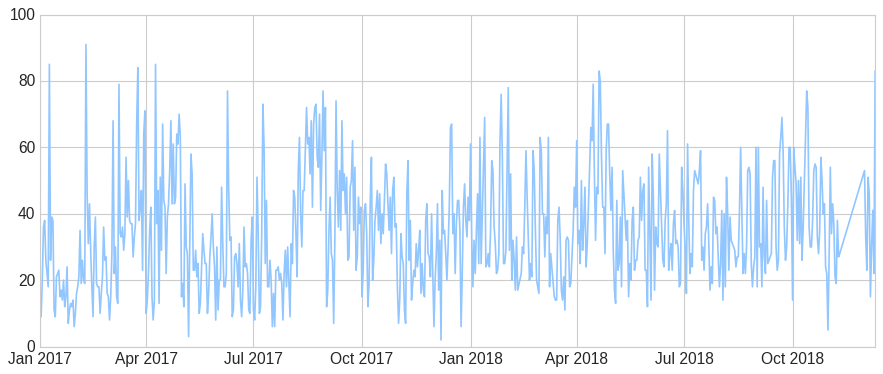

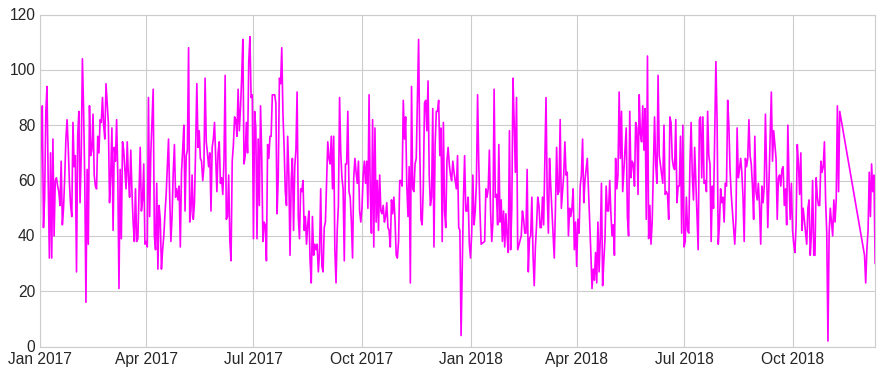

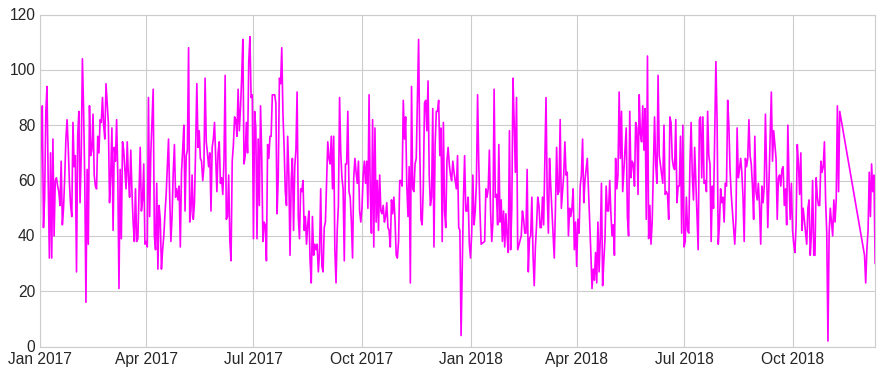

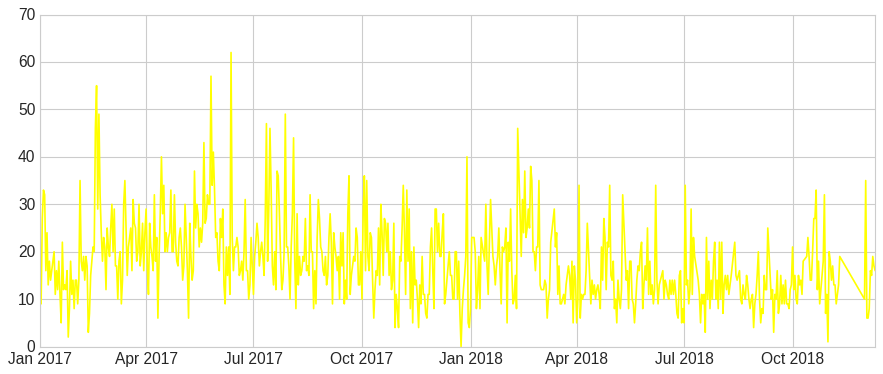

In [39]:
#Creating a plot showing demand for each segment
plt.plot(ltn_seg_final1.A2, label='A2',lw=1.5)
plt.show()
plt.plot(ltn_seg_final1.B1,label='B1', color='magenta',lw=1.5)
plt.show()
plt.plot(ltn_seg_final1.B3,label='B3', color='magenta',lw=1.5)
plt.show()
plt.plot(ltn_seg_final1.Other,label='Other', color='yellow',lw=1.5)
plt.show()

Based on this observation, it is clear overall booking patterns and market segment specific patterns follow different trends. A recommendation to the client will be to consider making individual forecasts for each of these market segments and planning their marketing and pricing strategies accordingly.

Next we still study the relation ship between price and ocupancy to better understand booking trends.

## Studying Price vs Demand

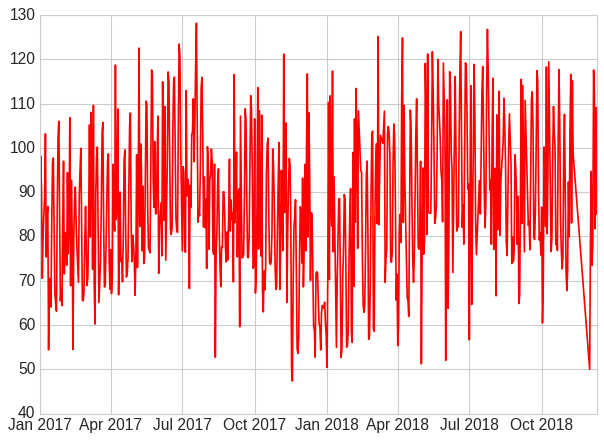

In [158]:
#plotting a graph showing average booking price per day
daily_price=ltn.groupby('Rs_Date')[['Rs_Rate']].mean()
plt.plot(daily_price,lw=1.5,color='red')
plt.show()

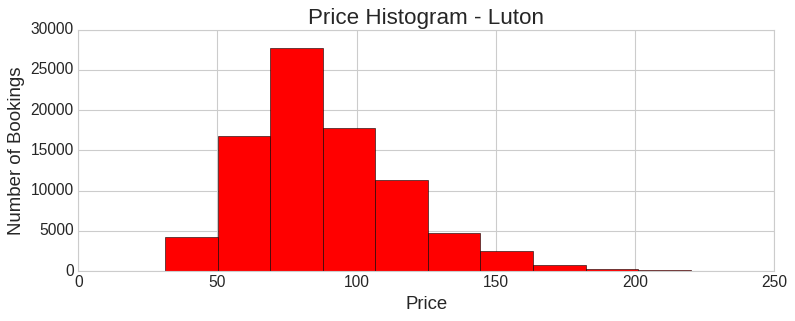

In [15]:
#plotting a histogram studying bookings vs price
plt.figure(3,figsize=(10, 8))
plt.subplot(211)
ltn.Rs_Rate.hist(color='red')
# Add title and axis names
plt.title('Price Histogram - Luton')
plt.xlabel('Price')
plt.ylabel('Number of Bookings')
plt.show(3)

In [44]:
ltn.Rs_Rate.describe()

count    86135.000000
mean        87.991405
std         27.669901
min         31.200000
25%         68.990000
50%         82.450000
75%        103.790000
max        219.990000
Name: Rs_Rate, dtype: float64

We observe that majority of the bookings are sold at a price point between 70 and 120. We will study the price demand relationship for these bookings. 

y=-57.434211x+(11999.868421)


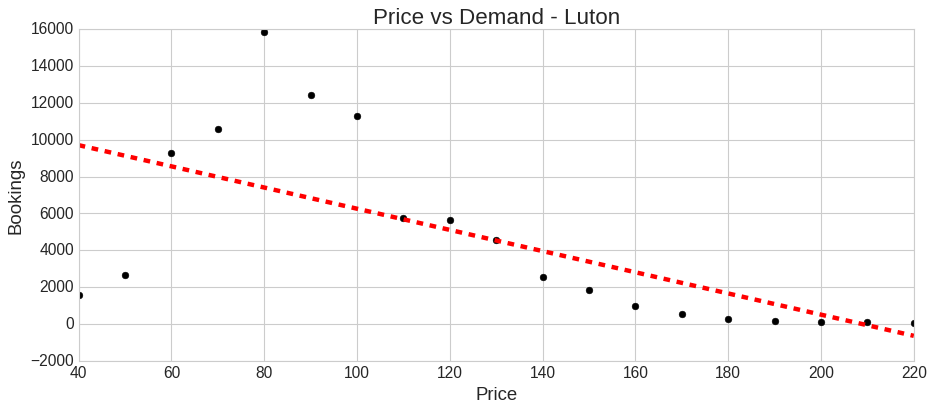

In [16]:
#Creating bins for the prices
bins = [30,40, 50, 60, 70, 80,90,100,110,120,130,140,150,160,170,180,190,200,210,220]
labels=[40, 50, 60, 70, 80,90,100,110,120,130,140,150,160,170,180,190,200,210,220]
ltn['Rs_Pricebin'] = pd.cut(ltn['Rs_Rate'], bins,labels=labels)

# plotting the price- demand trend line
rate =ltn.groupby(['Rs_Pricebin']).count()
rate['Rs_Pricebin'] = rate.index
#rate = rate[rate.Rs_Rate < 300]


# plot the data itself
x=rate['Rs_Pricebin'].as_matrix()
y=rate['Rs_Reserid'].as_matrix()
plt.plot(x,y,'o')

# calc the trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
# Add title and axis names
plt.title('Price vs Demand - Luton')
plt.xlabel('Price')
plt.ylabel('Bookings')
plt.plot(x,p(x),"r--")

# the line equation:
print ("y=%.6fx+(%.6f)"%(z[0],z[1]))

The trendline line indicates that guests are comfortable booking the property up to a price point of 80 pound per night after which demand decreases. An important factor to consider while studying elasticity of price is that pricing and demand are subject to competitor strategy as the lowest priced business airport hotel in the area will both.

In [17]:
rate.to_csv('rate_ltn.csv')

In [18]:
ltn.Rs_Rate.describe()

count    86135.000000
mean        87.991405
std         27.669901
min         31.200000
25%         68.990000
50%         82.450000
75%        103.790000
max        219.990000
Name: Rs_Rate, dtype: float64

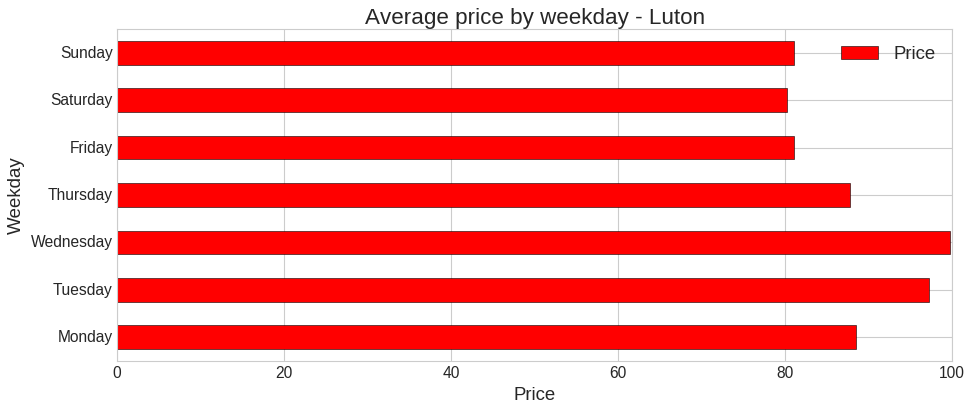

,Price
Rs_Date,
Monday,88.489996
Tuesday,97.257500
Wednesday,99.683919
Thursday,87.741383
Friday,81.098555
Saturday,80.214998
Sunday,81.018791


In [48]:
# studying average daily price for day of the week
weekday_price = ltn.groupby(ltn['Rs_Date'].dt.strftime('%A'))[['Rs_Rate']].mean()
weekday_price=weekday_price.reindex(["Monday", "Tuesday", "Wednesday","Thursday","Friday","Saturday","Sunday"])
weekday_price.columns=['Price']
weekday_price.plot(kind='barh',color='red', title='Average price by weekday - Luton')
# Add title and axis names
plt.title('Average price by weekday - Luton')
plt.xlabel('Price')
plt.ylabel('Weekday')
plt.show()
weekday_price

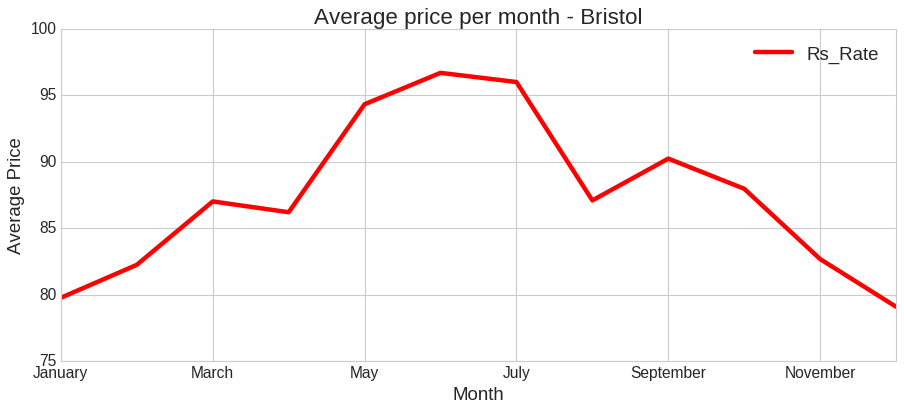

,Rs_Rate
Rs_Date,
January,79.763186
February,82.242304
March,87.015219
April,86.202025
May,94.334111
June,96.697694
July,96.007079
August,87.092849
September,90.240073


In [49]:
# studying average daily price per month
month_price = ltn.groupby(ltn['Rs_Date'].dt.strftime('%B'))[['Rs_Rate']].mean()
month_price=month_price.sort_values(by=['Rs_Date'])
month_price=month_price.reindex(["January", "February", "March","April","May","June","July","August","September","October","November","December"])
month_price.plot(color='red', title='Average price per month - Bristol')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.show()
month_price

we looked at the average daily price by day of week and observed that there is a cyclic trend because Tuesday and Wednesday show an average price that is just over 100 while the other days show an average price closer to 80. It is interesting to note that Monday, Thursday and Friday show a very similar demand as compared to Tuesday and yet their prices are significantly lower. Unless, this is a reaction to a competitor pricing strategy, there is scope for the Bristol chain to increase daily pricing on Thursday and Friday.<br>

We also looked at average daily price by day of month. We observe an increasing trend from January (80) to July (96) after which prices decrease again indicating high demand dudring the summer months. We can conclude there is a slight degree of seasonality with respect to pricing.

## Lead Time

Another important aspect of the booking process, is the days in advance the customer makes a booking prior to their stay. The histogram shows lead time trends. We observe that majority of the customers prefer making a booking between 1 and 20 days prior to their stay for both hotels with the average lead time being close to 1 month.

In [19]:
lead_price=ltn[ltn.Rs_lead>-1]
lp=lead_price
lp.Rs_lead.describe()

count    86130.000000
mean        27.346848
std         45.884896
min          0.000000
25%          1.000000
50%          9.000000
75%         32.000000
max        395.000000
Name: Rs_lead, dtype: float64

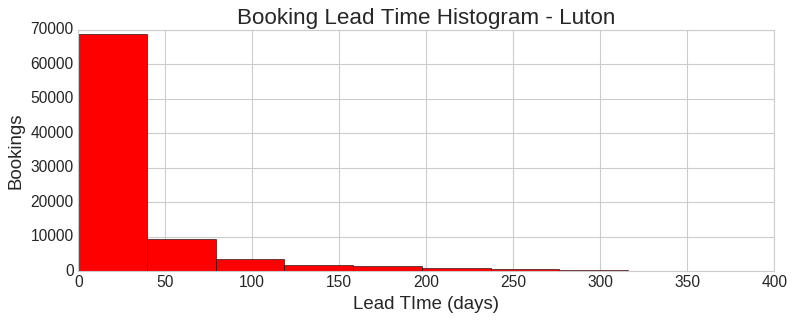

In [20]:
#plotting a histogram lead time vs occupancy
plt.figure(3,figsize=(10, 8))
plt.subplot(211)
lp.Rs_lead.hist(color='red')
plt.title('Booking Lead Time Histogram - Luton')
plt.xlabel('Lead TIme (days)')
plt.ylabel('Bookings')
plt.show(3)

y=-0.041449x+(87.502719)


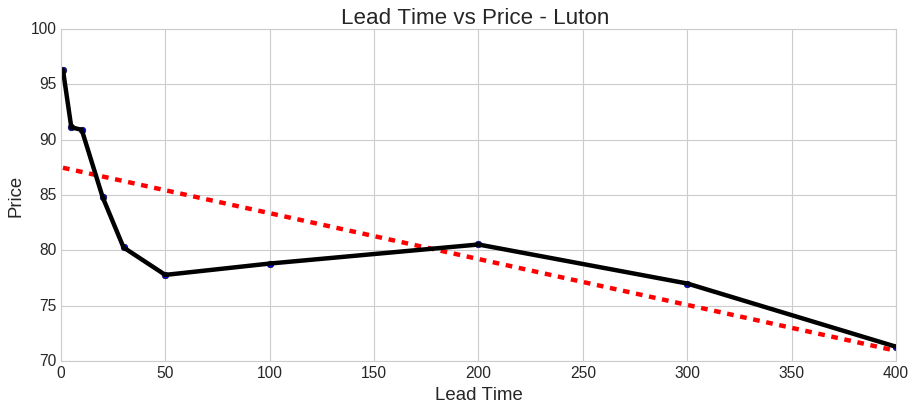

In [21]:
#studying the relationship between booking lead time and price

#Creating bins for the lead time
bins = [0,1,5, 10, 20, 30, 50,100,200,300,400]
labels=[1,5, 10, 20, 30, 50,100,200,300,400]
lead_price['Rs_leadbin'] = pd.cut(lead_price['Rs_lead'], bins,labels=labels)
lead_price=lead_price.groupby('Rs_leadbin')[['Rs_Rate']].mean()
lead_price['Rs_leadbin'] = lead_price.index

# plot the data itself
x=lead_price['Rs_leadbin'].as_matrix()
y=lead_price['Rs_Rate'].as_matrix()
plt.plot(x,y,'o',color='blue')

# calc the trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

# Add title and axis names
plt.title('Lead Time vs Price - Luton ')
plt.xlabel('Lead Time')
plt.ylabel('Price')

# the line equation:
print ("y=%.6fx+(%.6f)"%(z[0],z[1]))
plt.plot(x,y)
plt.show()

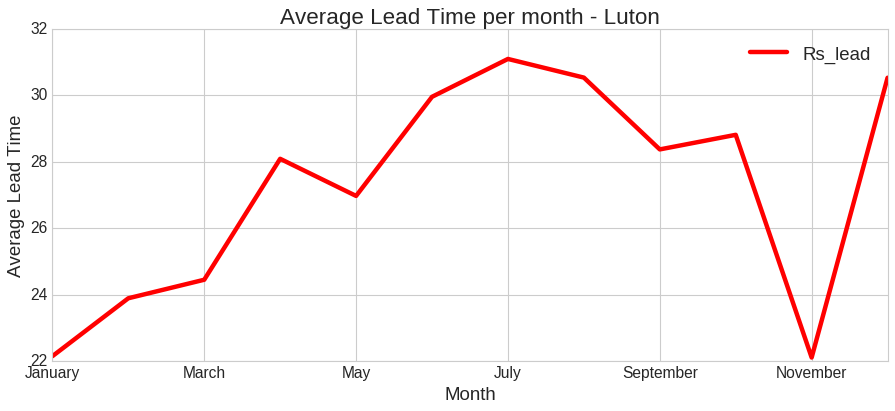

,Rs_lead
Rs_Date,
January,22.144507
February,23.889456
March,24.447698
April,28.089964
May,26.972184
June,29.957411
July,31.097971
August,30.536300
September,28.373184


In [53]:
#finding the average lead time for bookings made for each month
lpm=lp.groupby(lp['Rs_Date'].dt.strftime('%B'))[['Rs_lead']].mean()
lpm=lpm.reindex(["January", "February", "March","April","May","June","July","August","September","October","November","December"])
lpm.plot(color='red',title='Average Lead Time per month - Luton')
plt.xlabel('Month')
plt.ylabel('Average Lead Time')
plt.show()
lpm

We see that prices for majority of the bookings range between 70 to 110 pounds per night and can go as high as 346 for certain booking types. We also see an expected trend wherein demand decreases as we increase the price per night. Hotels generally tend to increase prices as the day of stay approaches. We plotted a trendline comparing price to lead time and we can clearly see that this is the case For Luton . Rooms are priced close to 95 on an average for a booking made a week in advance. 

### Outlier Treatment
Outliers are observations that are significantly different from the majority of the observations in the time series. We observe the daily occupancy shows a wide range of values for both the properties. Just by observing the trend line we can tell that majority of the time occupancy is above 62 for the Luton branch but dips below that threshold every once in a while. 

In descriptive statistics, a box plot is a method for graphically depicting groups of numerical data through their quartiles. Box plots may also have lines extending vertically from the boxes (whiskers) indicating variability outside the upper and lower quartiles, hence the terms box-and-whisker plot and box-and-whisker diagram. Outliers may be plotted as individual points.

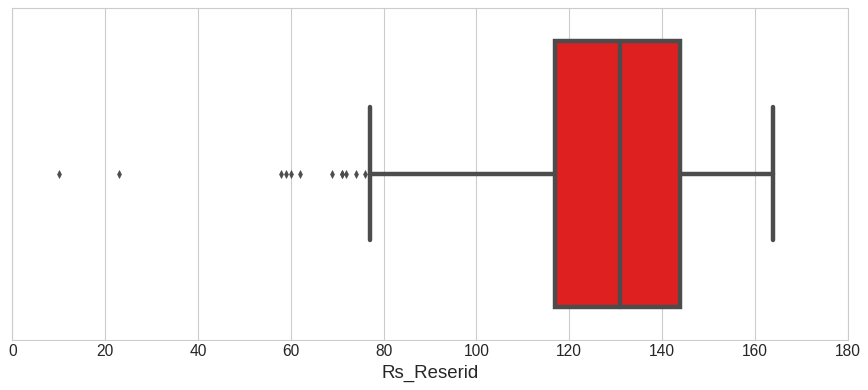

In [22]:
# plotting a box plot to study outliers in the occupancy data
import seaborn as sns
sns.boxplot(x=ltn_bookings['Rs_Reserid'],color='red')

In [159]:
#performing outlier treatment
outliers=[]
def detect_outlier(data_1):
    
    threshold=3
    mean_1 = np.mean(ltn_bookings.Rs_Reserid)
    std_1 =np.std(ltn_bookings.Rs_Reserid)
    
    for y in ltn_bookings.Rs_Reserid:
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return outliers

outlier_datapoints = detect_outlier(ltn_bookings)
print(outlier_datapoints)

[60, 62, 58, 10, 59, 23]


In [160]:
df_outlier=ltn_bookings[ltn_bookings['Rs_Reserid'] > 62]
df_outlier.mean()

Rs_Reserid    129.506787
dtype: float64

In [161]:
#replacing outliers with the average daily bookings(excluding outliers)
ltn_bookings['Rs_Reserid'].replace([60, 62, 58, 10, 59, 23],[129,129,129,129,129,129],inplace=True)
ltn_bookings.to_csv('ltn.csv')

We use the Z-score method to remove outliers for both the datasets. It is a way of describing a data point in terms of its relationship to the mean and standard deviation of a group of points. Taking a Z-score is simply mapping the data onto a distribution whose mean is defined as 0 and whose standard deviation is defined as 1. The intuition behind the Z-score method of outlier detection is that, once we’ve centred and rescaled the data, anything that is too far from zero (the threshold is usually a Z-score of 3 or -3) should be considered an outlier. (Gorrie,2016) We have used a threshold of 3 to filter out the outliers in both datasets and replaced the outliers with the mean of the non-outlier values to maintain a consistency in the data with respect to time period. A mean is suitable because the trend indicates no seasonality in the data and therefore using the mean doesn’t bias a future prediction made using that data point.

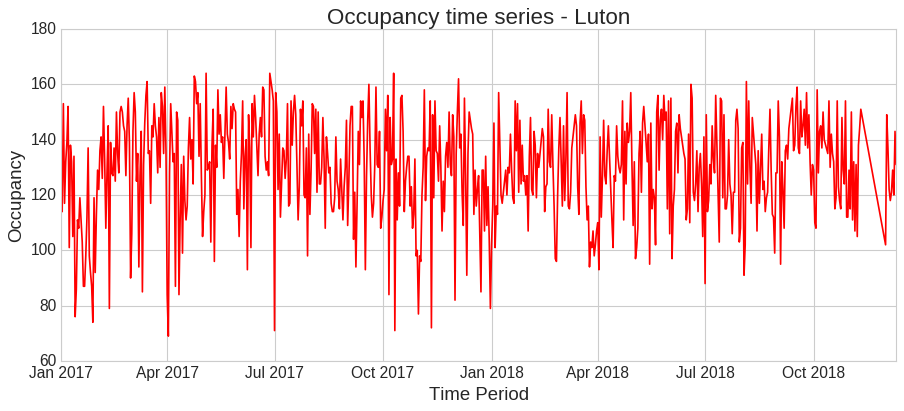

In [26]:
#viewing the booking trends for the Bristol hotel over the last 2 years
import matplotlib
matplotlib.rc('figure', figsize=(12, 5))
plt.plot(ltn_bookings.Rs_Date, ltn_bookings.Rs_Reserid, label='Actual',lw=1.5, color='red')

# Add title and axis names
plt.title('Occupancy time series - Luton')
plt.xlabel('Time Period')
plt.ylabel('Occupancy')
plt.show()

## 3. Naive Forecast

In order to establish a basic accuracy error level for the model, we have used Moving Average, Exponential Smoothening, persistence algorithm and walk forward approach to set a baseline.MA and Exponential Smoothening are used to see the forecast accuracy that can be achieved for a univariate single step forecast i.e occupancy forecast for the next day while the persistence algorithm and walk forward approach give a basic error estimate for a 90 day forecast. These forecasts will provide a baseline that will be useful while comparing the accuracy achieved with more advanced models.


In [27]:
#splitting the dataset into training and test
df= ltn_bookings
split_point = round((len(df)+1)/2)
train, test = df[0:split_point], df[split_point:]
ltn_training = train
ltn_test=test
print('Train %d, Test %d' % (len(train), len(test)))

Train 335, Test 334


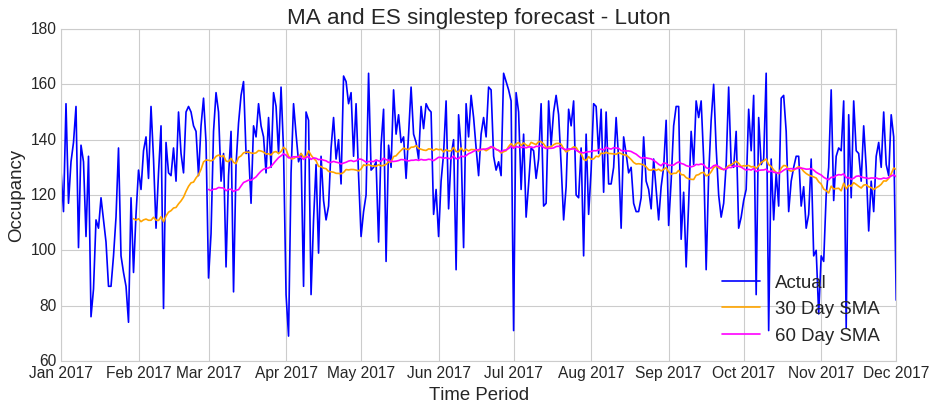

In [34]:
#Finding the 30 day moving average
import matplotlib
matplotlib.rc('figure', figsize=(12, 5))

rolling_mean = ltn_training.Rs_Reserid.rolling(window=30).mean()
rolling_mean_2 = ltn_training.Rs_Reserid.rolling(window=60).mean()
plt.plot(ltn_training.Rs_Date, ltn_training.Rs_Reserid, label='Actual',color='blue',lw=1.5)
plt.plot(ltn_training.Rs_Date, rolling_mean, label='30 Day SMA', color='orange',lw=1.5)
plt.plot(ltn_training.Rs_Date, rolling_mean_2, label='60 Day SMA', color='magenta',lw=1.5)
plt.legend(loc='lower right')
# Add title and axis names
plt.style.use('seaborn-whitegrid')
plt.title('MA and ES singlestep forecast - Luton')
plt.xlabel('Time Period')
plt.ylabel('Occupancy')
plt.show()

In [35]:
#Calculating forecast error and accuracy
ltn_MA=ltn_training.copy()
ltn_MA['SMA'] = ltn_MA.Rs_Reserid.rolling(window=30).mean()
ltn_MA=ltn_MA[(ltn_MA['Rs_Date'] > '2017-01-30')]

In [36]:
#calculating mape
import sklearn.utils 
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

ma_mape=mean_absolute_percentage_error(ltn_MA.Rs_Reserid, ltn_MA.SMA)
ma_mape

12.799481734126534

In [37]:
#calculating rmse
import math
from sklearn import metrics

def rmse(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return math.sqrt(metrics.mean_squared_error(y_true, y_pred))

ma_rmse=rmse(ltn_MA.Rs_Reserid, ltn_MA.SMA)
ma_rmse

19.552175306050803

In [38]:
#storing results for future comparison
singlestep_naive_forecast_error = pd.DataFrame(index = ['MAPE','RMSE'])
singlestep_naive_forecast_error['MA'] = [ma_mape, ma_rmse]

### Exponential Smoothening

In [39]:
#exponential smoothening
import numpy
import sklearn
def exponential_smoothing(panda_series, alpha_value):
    ouput=sum([alpha_value * (1 - alpha_value) ** i * x for i, x in 
                enumerate(reversed(panda_series))])
    return ouput

panda_series=ltn_bookings.Rs_Reserid
smoothing_number=exponential_smoothing(panda_series,0.1) 
estimated_values=ltn_test.copy() # replace testdata with your test dataset
estimated_values['SES'] = smoothing_number

In [40]:
#finding MAPE for exponential smoothening
from statsmodels.tsa.api import ExponentialSmoothing
exp = ExponentialSmoothing(ltn_training.Rs_Reserid) 

x=0.1
SE_mape={'smoothing level': [],'MAPE': [],'RMSE':[]}
while(x<1):
    exp_model = exp.fit(smoothing_level=x) 
    result_x = exp_model.fittedvalues 
    SE_mape['smoothing level'].append(x)
    SE_mape['MAPE'].append(mean_absolute_percentage_error(ltn_training.Rs_Reserid, result_x))
    SE_mape['RMSE'].append(rmse(ltn_training.Rs_Reserid, result_x))
    x+=0.1
    
pd.DataFrame(SE_mape)

,smoothing level,MAPE,RMSE
0,0.1,13.409419,19.994692
1,0.2,13.351009,20.178432
2,0.3,13.447118,20.535980
3,0.4,13.693070,20.986795
4,0.5,13.994607,21.502251
5,0.6,14.312458,22.083995
6,0.7,14.643081,22.747886
7,0.8,15.101934,23.516634
8,0.9,15.637943,24.416919
9,1.0,16.289038,25.478759


We observe that a smoothing constant of '0.1' gives the most accurate forecast. We will now compare the MA method vs Exponential Smoothening.

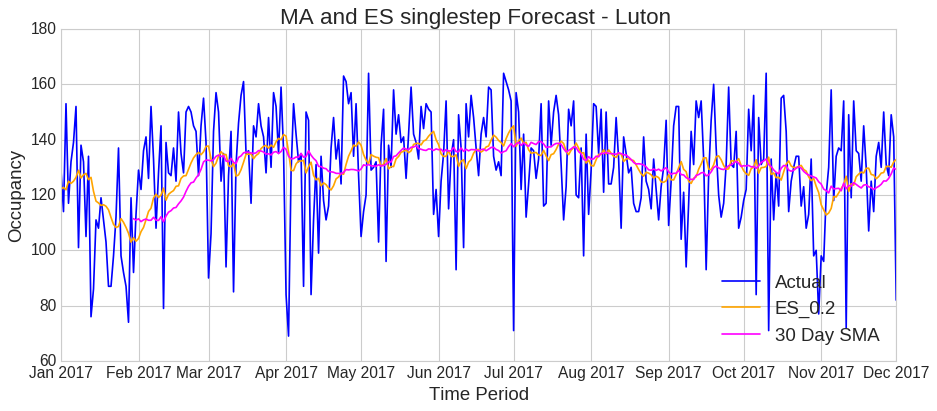

In [41]:
# comapring models
exp_model = exp.fit(smoothing_level=0.1) 
result = exp_model.fittedvalues 

plt.plot(ltn_training.Rs_Date, ltn_training.Rs_Reserid, label='Actual',color='blue',lw=1.5)
plt.plot(ltn_training.Rs_Date, result, label='ES_0.2', color='orange',lw=1.5)
plt.plot(ltn_training.Rs_Date, rolling_mean, label='30 Day SMA', color='magenta',lw=1.5)
plt.legend(loc='lower right')
# Add title and axis names
plt.title('MA and ES singlestep Forecast - Luton ')
plt.xlabel('Time Period')
plt.ylabel('Occupancy')
plt.show()

In [43]:
#adding results for comparison
singlestep_naive_forecast_error['ES'] = [13.409419, 19.994692]

In [44]:
singlestep_naive_forecast_error

,MA,ES
MAPE,12.799482,13.409419
RMSE,19.552175,19.994692


Overall, we observe the single-step forecasts show a good accuracy and give us a ballpark estimate for the error values that should be expected from the multi-step naive forecasts. In the next section, we look at the persistence algorithm.

# Multi step Naive Forecast

## Persistence Algorithm
A good baseline for time series forecasting is the persistence model. This is a forecasting model where the last observation is persisted forward. The persistence algorithm uses the value at the previous time step (t-1) to predict the expected outcome at the next time step t. In this analysis, we use the value at the previous time step(t-1) to predict the next 90 time steps (t,t+1,t+2,,t+3…t+89).This technique is the most common baseline forecast method for supervised machine learning. A major drawback is that it does not does not respect the serial correlation structure in time series datasets. The results are highlighted below-

In [45]:
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
import statistics
import math
from statistics import mean
from math import sqrt

# load dataset
series = read_csv('ltn.csv', header=0,  index_col=0, squeeze=True)
series = series.set_index('Rs_Date')

# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
	# extract raw values
	raw_values = series.values
	raw_values = raw_values.reshape(len(raw_values), 1)
	# transform into supervised learning problem X, y
	supervised = series_to_supervised(raw_values, n_lag, n_seq)
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return train, test

In [46]:
# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [47]:
# make a persistence forecast
def persistence(last_ob, n_seq):
	return [last_ob for i in range(n_seq)]

# evaluate the persistence model
def make_forecasts(train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = persistence(X[-1], n_seq)
		# store the forecast
		forecasts.append(forecast)
	return forecasts

In [60]:
overall_rmse = list()
overall_mape = list()
# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = test[:,(n_lag+i)]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = sqrt(mean_squared_error(actual, predicted))
		mape = np.mean(np.abs((actual - predicted) / actual)) * 100       
		overall_rmse.append(rmse)
		overall_mape.append(mape)
		print('t+%d RMSE: %f' % ((i+1), rmse))

# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	pyplot.plot(series.values,color='blue',lw=1.5)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - n_test + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = [series.values[off_s]] + forecasts[i]
        # Add title and axis names
		plt.title('Persistence Algorithm - Luton ')
		plt.xlabel('Time Period (Day)')
		plt.ylabel('Occupancy')
		pyplot.plot(xaxis, yaxis, color='red',lw=1.5)
	# show the plot
	pyplot.show()

t+1 RMSE: 24.235786
t+2 RMSE: 23.846873
t+3 RMSE: 25.161015
t+4 RMSE: 25.276999
t+5 RMSE: 24.889623
t+6 RMSE: 25.668398
t+7 RMSE: 26.227975
t+8 RMSE: 25.817501
t+9 RMSE: 25.577985
t+10 RMSE: 24.550832
t+11 RMSE: 25.384904
t+12 RMSE: 25.514506
t+13 RMSE: 24.804234
t+14 RMSE: 27.166892
t+15 RMSE: 25.882362
t+16 RMSE: 26.065558
t+17 RMSE: 26.030751
t+18 RMSE: 25.347321
t+19 RMSE: 26.404861
t+20 RMSE: 24.948013
t+21 RMSE: 25.866323
t+22 RMSE: 26.719032
t+23 RMSE: 26.992221
t+24 RMSE: 25.646897
t+25 RMSE: 25.790825
t+26 RMSE: 25.672813
t+27 RMSE: 25.570426
t+28 RMSE: 25.941408
t+29 RMSE: 23.852882
t+30 RMSE: 25.229678
t+31 RMSE: 25.473843
t+32 RMSE: 25.164393
t+33 RMSE: 25.491175
t+34 RMSE: 25.397047
t+35 RMSE: 26.310137
t+36 RMSE: 25.746456
t+37 RMSE: 25.074555
t+38 RMSE: 25.060061
t+39 RMSE: 24.784269
t+40 RMSE: 25.004533
t+41 RMSE: 25.741018
t+42 RMSE: 24.634258
t+43 RMSE: 26.392865
t+44 RMSE: 26.462993
t+45 RMSE: 24.580073
t+46 RMSE: 26.529795
t+47 RMSE: 23.506737
t+48 RMSE: 25.484570
t

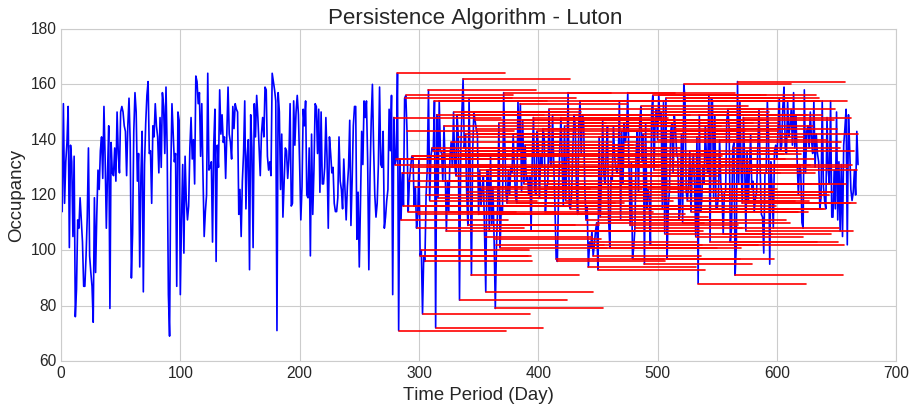

In [61]:
# configure
n_lag = 1
n_seq = 90
n_test = 300
# prepare data
train, test = prepare_data(series, n_test, n_lag, n_seq)
# make forecasts
forecasts = make_forecasts(train, test, n_lag, n_seq)
# evaluate forecasts
evaluate_forecasts(test, forecasts, n_lag, n_seq)
# plot forecasts
plot_forecasts(series, forecasts, n_test+89)

In [62]:
# Overall Accuracy Results
p_rmse=mean(overall_rmse)
p_mape=mean(overall_mape)
print("Overall RMSE for persistence Algorithm: ", p_rmse)
print("Overall MAPE for persistence Algorithm: ", p_mape)

Overall RMSE for persistence Algorithm:  25.171718703932797
Overall MAPE for persistence Algorithm:  16.33411288911383


In [63]:
#storing results for future comparison
multistep_naive_forecast_error = pd.DataFrame(index = ['MAPE','RMSE'])
multistep_naive_forecast_error['Persistence'] = [p_mape, p_rmse]

## Walk Forward Validation
Next, we use the walk forward approach which is a fundamental benchmark for forecasting that is flexible and requires no parameter identification. This basic model should be outperformed by more complex methods to warrant the additional complexity (Hyndman and Athanasopoulos,2014). Given the most recent actual daily occupancy yt, the forecast for 1 day ahead is calculated as yt+1 = yt. These values work reasonably well for multi-step forecasts and can be used as a benchmark for comparison and a starting point for further investigations. In this analysis we use occupancy values at t-1,t-2,t-3….t-90 to forecast expected occupancy at t,t+1,t+2…t+89. Each time step of the test dataset will be walked one at a time. A model will be used to make a forecast for the time step (90 days), then the actual expected value for the next quarter from the test set will be taken and made available to the model for the forecast on the next time step.

In [173]:
#Arima walk forward
import pandas as pd
from pandas.tseries.offsets import *
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from math import sqrt
from sklearn.metrics import mean_squared_error

def train_test_split(data):
    split = int(0.5 * len(data))
    train, test = data.iloc[:split], data.iloc[split:]
    return train, test

def x_y_split(data):
    X = data.loc[:,data.columns!='Rs_Reserid']
    y = data.loc[:,'Rs_Reserid']
    return X,y

def ml_split(data):
    train, test = train_test_split(data)
    Xtrain, ytrain = x_y_split(train)
    Xtest, ytest = x_y_split(test)
    return Xtrain, ytrain, Xtest, ytest

Xtrain, ytrain, Xtest, ytest = ml_split(ltn_bookings)

In [55]:
#Defining error measurement
#calculating RMSE
def rmse(ytest, ypred):
    test = []
    test.extend([list(ytest[i:i+90].values) for i in range(len(ytest))])
    rmse = sqrt(mean_squared_error(test[:-89],ypred[:-89]))
    return rmse

#calculating mape
import sklearn.utils 
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mape(ytest, ypred):
    test = []
    test.extend([list(ytest[i:i+90].values) for i in range(len(ytest))])
    mape = mean_absolute_percentage_error(test[:-89],ypred[:-89])
    return mape

#calculatin residuals
def residuals(ytest, ypred):
    test = []
    test.extend([list(ytest[i:i+90].values) for i in range(len(ytest))])
    residuals = test[:-89] - np.array(ypred[:-89]).reshape(np.array(test[:-89]).shape)
    return pd.DataFrame(residuals)

In [56]:
#performing naive Forecast
X = series.values
pyplot.figure(1)
index = 1

def naive_forecast(train, test):
    history = list(train)
    predictions = []
    for i in test:
        yhat = [x for x in history[-90:]]
        history.append(i)
        predictions.append(yhat)
    return predictions

prediction = naive_forecast(ytrain, ytest)
wf_mape = mape(ytest, prediction)
print('Overall MAPE for Walk Forward: %.3f' % wf_mape)
wf_rmse = rmse(ytest, prediction)
print('Overall RMSE for Walk Forward:',rmse(ytest, prediction))
r = residuals(ytest, prediction)

Overall MAPE for Walk Forward: 15.421
Overall RMSE for Walk Forward: 24.16540413485575


<Figure size 960x400 with 0 Axes>

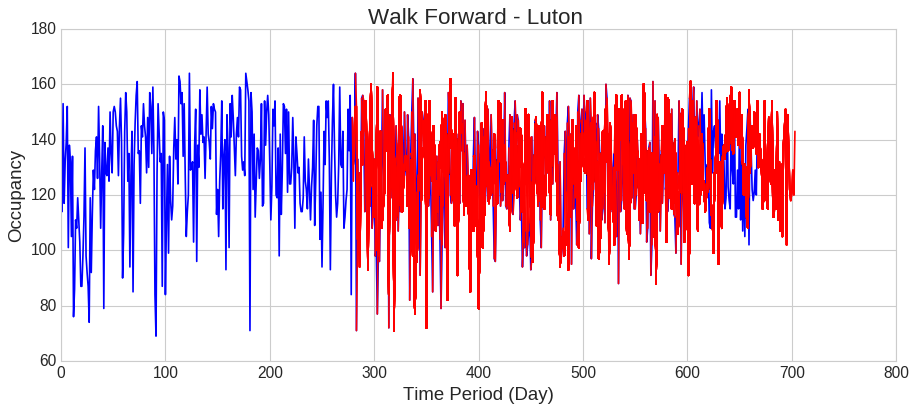

In [64]:
# plot forecasts
# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	pyplot.plot(series.values,color='blue',lw=1.5)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - n_test + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = [series.values[off_s]] + forecasts[i]
        # Add title and axis names
		plt.title('Walk Forward - Luton ')
		plt.xlabel('Time Period (Day)')
		plt.ylabel('Occupancy')
		pyplot.plot(xaxis, yaxis, color='red',lw=1.5)
	# show the plot
	pyplot.show()
plot_forecasts(series, prediction, n_test+89)

In [65]:
#adding results for comparison
multistep_naive_forecast_error['Walk Forward'] = [wf_mape, wf_rmse]
multistep_naive_forecast_error

,Persistence,Walk Forward
MAPE,16.334113,15.420961
RMSE,25.171719,24.165404


For Luton, the models are wrong by ~25 rooms per day and the error percentage is about 16%. 

Evaluating the forecast errors from the naïve forecast, we see that the ES and MA methods show a higher accuracy and smaller error rate compared to the persistence and WF. However, we will not be comparing these values to the final forecast results from the advanced techniques as a multistep model with a large forecast horizon is bound to show a lower forecast accuracy than these basic single step model. Therefore, we use the results from the multistep naive forecast as our benchmark for future models. 

The next section focuses on building a 90-day forecast model that outperforms the accuracy levels of the naïve forecast.

## 4. ARIMA
The ARMA model was developed to provide a general framework for forecasting non-stationary observed time series data and can be estimated using the Box-Jenkins approach. The model can be considered as a special type of regression model in which the dependent variable has been stationarized and the independent variables are all lags of the dependent variable and/or lags of the errors. The AR part of ARIMA indicates that the evolving variable of interest is regressed on its own prior values. The MA part indicates that the regression error is actually a linear combination of error terms whose values occurred contemporaneously and at various times in the past. The "Integrated" indicates that the data values have been replaced with the difference between their values and the previous values and this differencing process may have been performed more than once. The purpose of each of these features is to make the model fit the data as well as possible.

We will start by making sure the time series is stationary using the Dickey Fuller method. We will then configure the ARIMA(p,d,q) model by finding the ideal order for each of the components and finally check the accuracy of the forecast.

### 4.1 Checking stationarity 
Analysis of the time series data assumes that we are working with a stationary time series. However, in most cases data is usually non-stationary. We can make it stationary by first differencing the series and using a statistical test to confirm that the result is stationary.

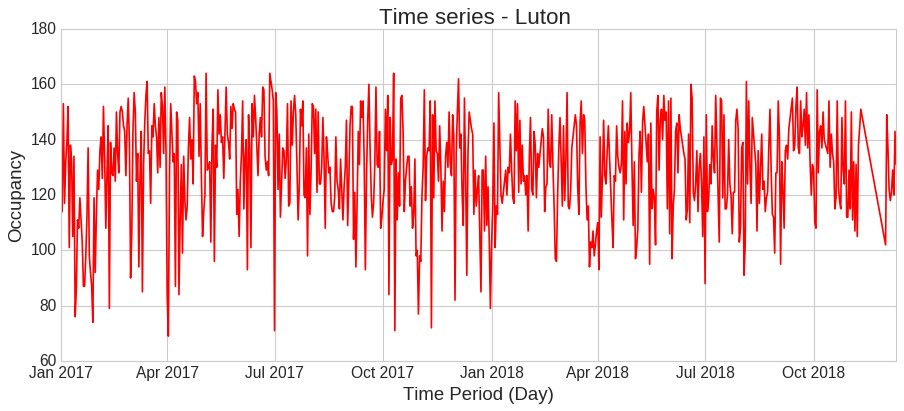

In [66]:
# plot original time series
plt.plot(ltn_bookings.Rs_Date, ltn_bookings.Rs_Reserid, label='Actual',color='red',lw=1.5)
plt.title('Time series - Luton ')
plt.xlabel('Time Period (Day)')
plt.ylabel('Occupancy')
plt.show()

The plot does not show any obvious seasonality or trend. We can use the the augmented Dickey-Fuller statistical significance test to check that the output series is stationary.

In [67]:
# check if stationary
from statsmodels.tsa.stattools import adfuller

# check if stationary
series = ytrain.append(ytest)
result = adfuller(series)
print('ADF Statistic: %f' % result[0]) 
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value)) 

ADF Statistic: -9.068615
p-value: 0.000000
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


The results show that the test statistic value -9.1 is smaller than the critical value at 1% of -3.44. This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke). Correspondingly, this implies that our time series variable is stationary.

We can proceed with the ARIMA forecasting. Note that should our time series have possessed a unit root, we would need to induce stationarity by first-differencing the series, before proceeding. To configure the ARIMA, we look at the ACF and PACF plots choose the appropriate lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q, respectively.

### 4.2 Manually Configure the ARIMA

The ARIMA (p,d,q) model requires three parameters and is generally configured manually. The first step is to select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively. We did this by studying the Autocorrelation and Partial Autocorrelation plots. This was done by examining the booking data for trends and variability using visual analysis of the auto-correlation function (ACF) and partial autocorrelation function (PACF) plots. The plots can be used to determine to what extent and magnitude the past values of hotel occupancy are related to future values. These plots provide an insight in to how reliable past booking data is for forecasting future demand.

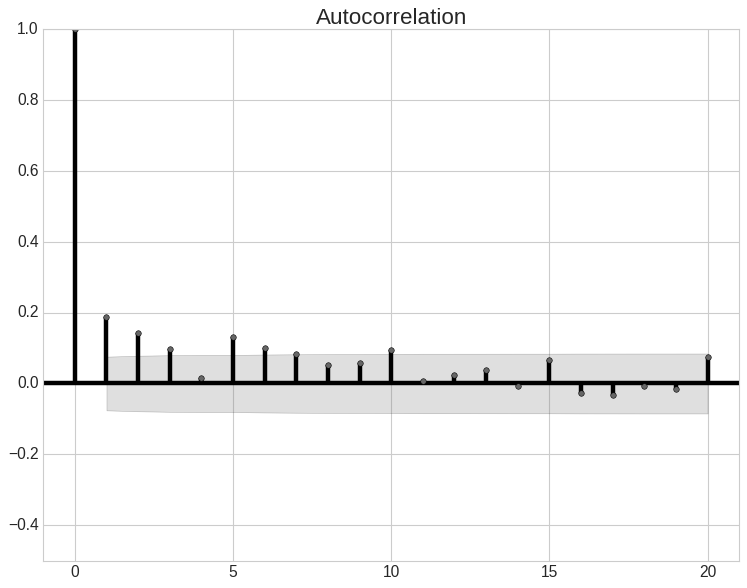

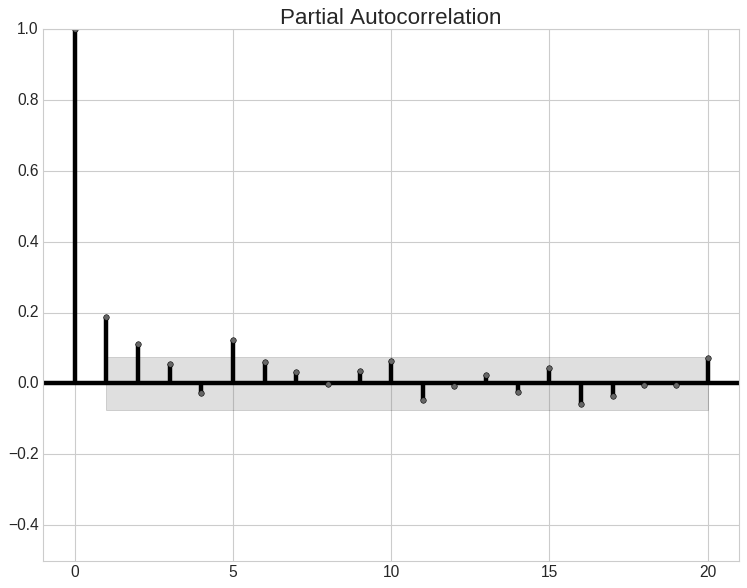

In [68]:
# ACF and PACF plots of time series
from pandas import Series
from statsmodels.graphics.tsaplots import plot_acf 
from statsmodels.graphics.tsaplots import plot_pacf 
import pylab
#series = Series.from_csv('stationary.csv')
#stationary 

plt.figure(6,figsize=(10, 8)) 
plt.plot(211)
pylab.ylim([-0.5,1])
plot_acf(series, ax=plt.gca(),lags=20) 

plt.figure(7,figsize=(10, 8)) 
plt.plot(212)
pylab.ylim([-0.5,1])
plot_pacf(series, ax=plt.gca(),lags=20)
plt.show()

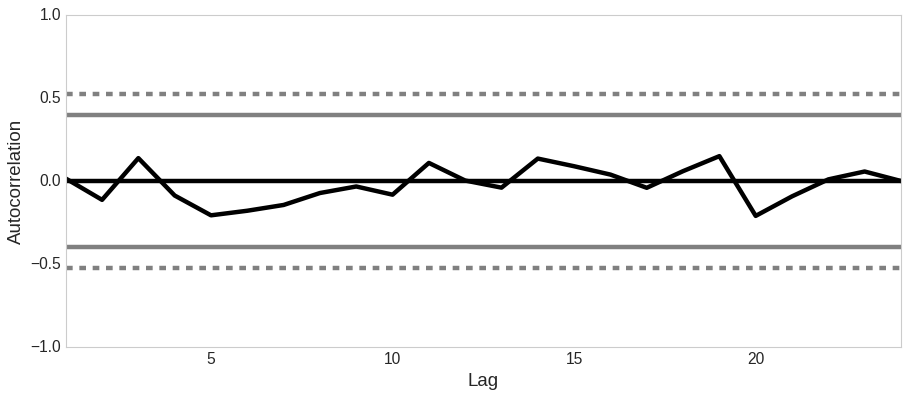

In [69]:
#Observing the correlation plot to data aggregated at a monthly level
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt

L_quarter=ltn_bookings
L_quarter['Rs_Date'] = pd.to_datetime(L_quarter['Rs_Date'])
L_quarter=L_quarter.set_index('Rs_Date')
L_q=L_quarter.resample('M').mean()
autocorrelation_plot(L_q)

We can make the following observations from the above plots-<br>
- ACF shows a significant lag for 1 month,with perhaps some significant lag for later months<br>
- PACF shows a significant lag for 1 month.

### 5.3 Running the ARIMA model
Based on the ARIMA parameters identified in the previous section we ran the model for different combinations of p, d and q. We use an ARIMA model with parameters p=1, d=0 and q=1 as the base because this configuration suggests that the value of the current period is related to both, some function of its previous value (Autoregressive model of first order) as well as to the random error from the previous period (Moving Average of first order), plus an error term. The model starts off with assuming only a locally linear relationship to its directly preceding value. From there, more complicated sequences are examined as well. 

In [70]:
# grid search for best sarima parameters
from pyramid.arima import auto_arima

def search_arima(train):
    stepwise_model = auto_arima(train, start_p=0,start_d=0,max_d=1,start_q=0,max_p =2, max_q=2, m=7,
                               start_P=0, seasonal=False, trace=True, error_action='ignore',  
                               suppress_warnings=True, stepwise=True
                               )
    print("Selected model:",stepwise_model)
    return stepwise_model.order, stepwise_model.seasonal_order

In [71]:
def sarima_forecast(train, test):
    order, s_order = search_arima(train)    
    predictions = []
    x = test.index
    for i in x:
        model = SARIMAX(train, order = order, seasonal_order = s_order)
        model_fit = model.fit(disp = False, method = 'powell', maxiter = 200)
        yhat = model_fit.predict(len(test), len(test)+89)
        predictions.append(list(yhat.values))
        train = train.append(test.iloc[0:1])
        train.index.freq = 'D' #fixes warnings with arima
        test = test.iloc[1:]
    return predictions

search_arima(ytrain)

Fit ARIMA: order=(0, 0, 0); AIC=2962.922, BIC=2970.544, Fit time=0.024 seconds
Fit ARIMA: order=(1, 0, 0); AIC=2948.055, BIC=2959.489, Fit time=0.024 seconds
Fit ARIMA: order=(0, 0, 1); AIC=2951.442, BIC=2962.876, Fit time=0.023 seconds
Fit ARIMA: order=(2, 0, 0); AIC=2945.276, BIC=2960.521, Fit time=0.039 seconds
Fit ARIMA: order=(2, 0, 1); AIC=2942.510, BIC=2961.565, Fit time=0.155 seconds
Fit ARIMA: order=(1, 0, 1); AIC=2941.874, BIC=2957.119, Fit time=0.112 seconds
Fit ARIMA: order=(1, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 2); AIC=2940.175, BIC=2963.042, Fit time=0.263 seconds
Total fit time: 0.665 seconds
Selected model: ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(2, 0, 2),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=None, solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend='c')


((2, 0, 2), None)

AIC is an estimate of a constant plus the relative distance between the unknown true likelihood function of the data and the fitted likelihood function of the model. A lower AIC means a model is considered to be closer to the truth. BIC is an estimate of a function of the posterior probability of a model being true, under a certain Bayesian setup. A lower BIC means that a model is considered to be more likely to be the true model.

Therefore, we see that for the given time series an ARIMA model of order (2,0,2) has the lowest AIC (2,940) and BIC (2,963). We now see the accuracy results for this model-<br>


In [72]:
# evaluate manually configured ARIMA model
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt


# invert differenced value
def inverse_difference(history, yhat, interval=0):
    return yhat + history[-interval]

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt

a=len(test)
b=len(test)+89

def arima_forecast(train, test):
    predictions = []
    x = test.index 
    for i in x:
        model = ARIMA(train, order=(2,0,2))
        model_fit = model.fit(disp=False)
        yhat = model_fit.predict(a,b)
        predictions.append(list(yhat.values))
        train = train.append(test.iloc[0:1])
        train.index.freq = 'D' #fixes warnings with arima
        test = test.iloc[1:]
    return predictions

arima_predictions = arima_forecast(ytrain, ytest)
arima_pred=arima_predictions

In [73]:
#calculating error
arima_rmse = rmse(ytest,arima_predictions)
print('ARIMA RMSE: %.3f' % rmse(ytest,arima_predictions))
arima_mape = mape(ytest, arima_predictions)
print('ARIMA MAPE: %.3f' % arima_mape)
r = residuals(ytest,arima_predictions)

ARIMA RMSE: 17.846
ARIMA MAPE: 11.851


The next step is to apply bias adjustment to the results to further improve accuracy. A forecast bias occurs when there are consistent differences between the predictions and the actual values observed. We can neutralize any forecast bias by adding the average residual error observed between the test set and predictions to the predictions and observing whether this reduces forecast error. The results are shown below.

In [74]:
#calculating error after performing Bias Adjustment
bias = r.describe().iloc[1].values
arima_rmse_be = rmse(ytest, arima_predictions + bias)
arima_mape_be = mape(ytest, arima_predictions + bias)
print('ARIMA RMSE with bias adjustment: %.3f'% arima_rmse_be)
print('ARIMA MAPE with bias adjustment: %.3f' %arima_mape_be)

ARIMA RMSE with bias adjustment: 17.116
ARIMA MAPE with bias adjustment: 11.567


In [75]:
#storing results for future comparison
advanced_forecast_error = pd.DataFrame(index = ['MAPE','RMSE'])
advanced_forecast_error['ARIMA'] = [arima_mape_be, arima_rmse_be]

Therefore, we observe that applying bias adjustment increases the accuracy of the ARIMA model and these values are the final forecast error achieved for this method. We observe that the tuned ARIMA model achieves an accuracy that is significantly better than the naïve forecast. Next, we will use supervised learning to build a forecast.

<h1> 6. Supervised Learning (Random Forest) </h1>

In the previous section, we have trained an ARIMA model on the time series booking data. In this section, we will frame time series forecasting as a supervised learning problem. This re-framing of the data allows us access to the suite of standard linear and nonlinear machine learning algorithms that can be used to make predictions. Essentially, supervised learning problem is comprised of input patterns (X) and output patterns (y), such that an algorithm can learn how to predict the output patterns from the input patterns. The figure below illustrates how the data was converted. We have included average price and average booking lead time per day as features

In [162]:
# framing time period features
ltn_bookings=ltn_1.groupby(['Rs_Date']).count()
ltn_bookings.reset_index(level=0, inplace=True)
ltn_bookings['Rs_Date'] = pd.to_datetime(ltn_bookings['Rs_Date'])
ltn_bookings=ltn_bookings.sort_values(by=['Rs_Date'])

sl_df = ltn_bookings
sl_df['week'] = sl_df.Rs_Date.map(lambda x: x.week)
sl_df['month'] = sl_df.Rs_Date.map(lambda x: x.month)
sl_df['year'] = sl_df.Rs_Date.map(lambda x: x.year)
sl_df['dayofweek'] = sl_df.Rs_Date.map(lambda x: x.dayofweek)
sl_df['weekend_flag'] = sl_df.dayofweek > 5
sl_df['season'] = sl_df['month']%12//3 # 0-winter 1-spring 2-summer 3-autumn
sl_df = sl_df.set_index(['Rs_Date'])
sl_df = sl_df.dropna()
reframed_df1 = pd.merge(sl_df, daily_price,left_index=True,right_index=True, how='left')
daily_lead1=ltn.groupby('Rs_Date')[['Rs_lead']].mean()
reframed_df = pd.merge(reframed_df1, daily_lead1,left_index=True,right_index=True, how='left')
reframed_df.to_csv('Bristol_TS.csv')
reframed_df.head()

,Rs_Reserid,week,month,year,dayofweek,weekend_flag,season,Rs_Rate,Rs_lead
Rs_Date,,,,,,,,,
2017-01-01,60,52,1,2017,6,True,0,70.165667,34.333333
2017-01-02,114,1,1,2017,0,False,0,98.149211,9.640351
2017-01-03,153,1,1,2017,1,False,0,90.589608,16.405229
2017-01-04,117,1,1,2017,2,False,0,70.548034,23.803419
2017-01-05,132,1,1,2017,3,False,0,79.706364,29.030303


In [163]:
# convert series to supervised learning

def series_to_supervised(data):
    df = pd.DataFrame(data)
    cols, names = [],[]

    cols.append(data.shift(1))
    names.extend([(col+'(t-1)') for col in data.columns])

    cols.append(data.iloc[:,0])
    names.append(data.columns[0])

    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg[1:-1]

In [164]:
# frame as supervised learning
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

supervised_df = series_to_supervised(reframed_df)
X = supervised_df.loc[:,supervised_df.columns!='Rs_Reserid']
y = supervised_df.loc[:,'Rs_Reserid(t-1)']
Xvalues = X.values
yvalues = y.values
Xvalues, yvalues = Xvalues.astype('float32'), yvalues.astype('float32')

#normalize features
Xscaler, yscaler = MinMaxScaler(feature_range=(0, 1)), MinMaxScaler(feature_range=(0, 1))

Xscaled = Xscaler.fit_transform(Xvalues)
yscaled = yscaler.fit_transform(yvalues.reshape(-1,1))

Xscaled = pd.DataFrame(Xscaled, index=X.index, columns=X.columns)
yscaled = pd.DataFrame(yscaled, index=y.index, columns=['Rs_Reserid'])

scaled = pd.concat([Xscaled, yscaled], axis=1)
scaled.head()

,Rs_Reserid(t-1),week(t-1),month(t-1),year(t-1),dayofweek(t-1),weekend_flag(t-1),season(t-1),Rs_Rate(t-1),Rs_lead(t-1),Rs_Reserid
Rs_Date,,,,,,,,,,
2017-01-02,0.324675,1.0,0.0,0.0,1.000000,1.0,0.0,0.282276,0.398067,0.324675
2017-01-03,0.675325,0.0,0.0,0.0,0.000000,0.0,0.0,0.628418,0.055220,0.675325
2017-01-04,0.928571,0.0,0.0,0.0,0.166667,0.0,0.0,0.534909,0.149146,0.928571
2017-01-05,0.694805,0.0,0.0,0.0,0.333333,0.0,0.0,0.287006,0.251866,0.694805
2017-01-06,0.792208,0.0,0.0,0.0,0.500000,0.0,0.0,0.400289,0.324438,0.792208


We will now train a random forest model on the supervised learning formulation of our time series data.

### Tuning the Model
We will be using the Random Forest technique to forecast the data. We will first create a forecast using the default Random Forest parameters and then tune it using a Random Search classifier that uses the walk forward approach for validation. The parameters of the basic and tuned models along with their forecast performance are shown below. We observe that the tuned model slightly outperforms the default model.

In [80]:
# Look at parameters used by our current forest

from sklearn.ensemble import RandomForestRegressor

RF = RandomForestRegressor()
print('Parameters currently in use:\n')
print(RF.get_params())

Parameters currently in use:

{'bootstrap': True, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 'warn', 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [166]:
#splitting into train,test
train, test = train_test_split(scaled)

#creating time series splits for tuning and validation
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

estimators=10
model = RandomForestRegressor()
tscv = TimeSeriesSplit(n_splits=3)

#creating a configuration grid

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(100, 500, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [False]
# Create the random grid
params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
params

{'n_estimators': [100, 325, 550, 775, 1000],
 'max_features': ['auto', 'sqrt', 'log2'],
 'max_depth': [100, 200, 300, 400, 500, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [False]}

In [167]:
# Performing parameter tuning

from sklearn.model_selection import GridSearchCV

for i in range(3):
    tscv = TimeSeriesSplit(n_splits=3)
    model = RandomForestRegressor()
    finder = GridSearchCV(
            estimator=model,
            param_grid=params,
            scoring='neg_mean_squared_error', 
            fit_params=None,
            n_jobs=None,
            iid=False,
            refit=False,
            cv=tscv,  
            verbose=1,
            return_train_score=False)

    finder.fit(Xtrain, ytrain)
    best_params = finder.best_params_ 

Fitting 3 folds for each of 810 candidates, totalling 2430 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2430 out of 2430 | elapsed: 10.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 810 candidates, totalling 2430 fits


[Parallel(n_jobs=1)]: Done 2430 out of 2430 | elapsed: 10.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 810 candidates, totalling 2430 fits


[Parallel(n_jobs=1)]: Done 2430 out of 2430 | elapsed: 10.6min finished


In [170]:
best_params

{'bootstrap': False,
 'max_depth': 100,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 325}

In [184]:
#Using the random forest method to create a forecast

def random_forest(train, test):
    predictions = []
    model = RandomForestRegressor(n_estimators = 739,
     min_samples_split = 2,
     min_samples_leaf = 1,
     max_features= 'auto',
     max_depth = 216,
     bootstrap= True)
    x = test.index
    for i in x:
        Xtrain, ytrain = x_y_split(train)
        Xtest, ytest = x_y_split(test)
        model.fit(Xtrain, ytrain)
        yhat = model.predict((Xtest))[:90]
        predictions.append(list(yhat))
        train = train.append(test.iloc[0])
        test = test.iloc[1:]
    return predictions

train, test = train_test_split(scaled)
predictions = random_forest(train, test)
ypred = pd.DataFrame(predictions, index = test.index)
for i in ypred.columns:
    ypred[i] = yscaler.inverse_transform(ypred[i].to_frame())

RF_pred=ypred[0]

In [192]:
#calculating error
#RF_rmse = sqrt(mean_squared_error(ytest[0:334], ypred[0]))
#RF_mape = mean_absolute_percentage_error(ytest[0:334], ypred[0])
#print('RF RMSE: %.3f' % RF_rmse)
#print('RF MAPE: %.3f' % RF_mape)
print('RF RMSE: ',22.812)
print('RF MAPE: ',14.837)

RF RMSE:  22.812
RF MAPE:  14.837


In [193]:
#calculating error with bias adjustment
#r = ytest[0:334]-ypred[0].values
#bias = mean(r)
#ypredr=ypred[0]+bias
#RF_rmse_be = sqrt(mean_squared_error(ytest[0:334], ypredr))
#RF_mape_be = mean_absolute_percentage_error(ytest[0:334], ypredr)
#print('RF RMSE with bias adjustment: %.3f' % RF_rmse_be)
#print('RF MAPE with bias adjustment: %.3f'% RF_mape_be)
print('RF RMSE with bias adjustment: ',22.443)
print('RF MAPE with bias adjustment: ',14.797)

RF RMSE with bias adjustment:  22.443
RF MAPE with bias adjustment:  14.797


In [90]:
#Storing results
advanced_forecast_error['Random Forest'] = [RF_mape_be, RF_rmse_be]

We observe that the Random Forest method outperforms the multistep naïve forecasts but shows an accuracy error higher than the ARIMA model for both hotels. In the next section we will develop an LSTM forecast.

<h1> 7. LSTM </h1>

In order to configure the model, a simple structure with 1 hidden layer and 1 LSTM unit was used alongside an output layer with linear activation and 90 output values. The network uses a mean squared error loss function and the ‘ADAM’ optimization algorithm. The network was initially fitted for 100 epochs and 30 neurons. The number of epochs indicates how many times the processor goes through the training set and the neurons indicates the number of nodes used in the hidden LSTM layer. The same batch size of 1 is used for training and prediction as we require predictions to be made at each time step of the test dataset. A batch size of 1 is also called online learning as the network weights will be updated during training after each training pattern. The model is updated each time a batch is processed, which means that it can be updated multiple times during one epoch. (Brownlee, 2017). The LSTM model was manually tuned to find the ideal neuron- epochs combination. The results are shown below-

In [91]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array

# load dataset
series = ytrain.append(ytest)
 
# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

Using TensorFlow backend.


In [92]:
# create a differenced series
def difference(dataset, interval=0):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
	# extract raw values
	raw_values = series.values
	# transform data to be stationary
	diff_series = difference(raw_values, 1)
	diff_values = diff_series.values
	diff_values = diff_values.reshape(len(diff_values), 1)
	# rescale values to -1, 1
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaled_values = scaler.fit_transform(diff_values)
	scaled_values = scaled_values.reshape(len(scaled_values), 1)
	# transform into supervised learning problem X, y
	supervised = series_to_supervised(scaled_values, n_lag, n_seq)
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return scaler, train, test

In [93]:
# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
	# reshape training into [samples, timesteps, features]
	X, y = train[:, 0:n_lag], train[:, n_lag:]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	# design network
	model = Sequential()
	model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(y.shape[1]))
	model.compile(loss='mean_squared_error', optimizer='adam')
	# fit network
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
		model.reset_states()
	return model
 
# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
	# reshape input pattern to [samples, timesteps, features]
	X = X.reshape(1, 1, len(X))
	# make forecast
	forecast = model.predict(X, batch_size=n_batch)
	# convert to array
	return [x for x in forecast[0, :]]

In [94]:
# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = forecast_lstm(model, X, n_batch)
		# store the forecast
		forecasts.append(forecast)
	return forecasts
 
# invert differenced forecast
def inverse_difference(last_ob, forecast):
	# invert first forecast
	inverted = list()
	inverted.append(forecast[0] + last_ob)
	# propagate difference forecast using inverted first value
	for i in range(1, len(forecast)):
		inverted.append(forecast[i] + inverted[i-1])
	return inverted

In [95]:
# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
	inverted = list()
	for i in range(len(forecasts)):
		# create array from forecast
		forecast = array(forecasts[i])
		forecast = forecast.reshape(1, len(forecast))
		# invert scaling
		inv_scale = scaler.inverse_transform(forecast)
		inv_scale = inv_scale[0, :]
		# invert differencing
		index = len(series) - n_test + i - 1
		last_ob = series.values[index]
		inv_diff = inverse_difference(last_ob, inv_scale)
		# store
		inverted.append(inv_diff)
	return inverted

over_rmse=list()
over_mape=list()
LSTM_pred=list()
# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = [row[i] for row in test]
		predicted = [forecast[i] for forecast in forecasts]
		LSTM_pred.append(predicted)      
		rmse = sqrt(mean_squared_error(actual, predicted))
		mpe = mean_absolute_percentage_error(actual,predicted)
		over_rmse.append(rmse)
		over_mape.append(mpe)     
		print('t+%d RMSE: %f' % ((i+1), rmse))

# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	pyplot.plot(series.values)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - n_test + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = [series.values[off_s]] + forecasts[i]
		pyplot.plot(xaxis, yaxis, color='red')
	# show the plot
	pyplot.show()

<function matplotlib.pyplot.show(*args, **kw)>

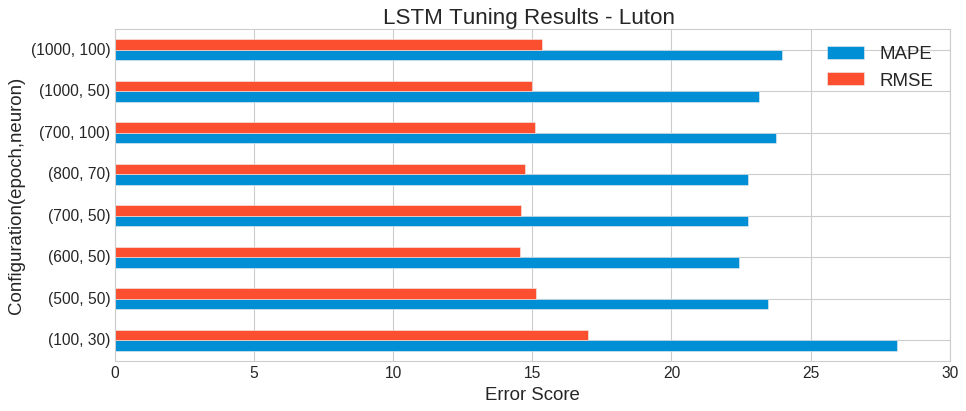

In [169]:
#500,1,50 - rmse:23.45179745002151 mape:15.125611081569557
#1000,1,100- rmse:23.973590983291746 mape: 15.354156262369784
#700,1,50 - rmse:22.74778823155697 mape: 14.584212142607942
#800,1,70 - rmse:22.74778823155697 mape: 14.723394069952546
#600,1,100

import matplotlib
matplotlib.rc('figure', figsize=(12, 5))
plt.style.use('seaborn-whitegrid')

#storing results for LSTM configuration
LSTM_Tune = pd.DataFrame(index = ['MAPE','RMSE'])
LSTM_Tune[100,30] = [28.104, 16.987]
LSTM_Tune[500,50] = [23.451, 15.125]
LSTM_Tune[600,50] = [22.443, 14.561]
LSTM_Tune[700,50] = [22.747, 14.584]
LSTM_Tune[800,70] = [22.747, 14.723]
LSTM_Tune[700,100] = [23.768, 15.114]
LSTM_Tune[1000,50] = [23.150, 15.005]
LSTM_Tune[1000,100] = [23.9735, 15.354]
LSTM_Tune.transpose()
plt.style.use('seaborn-whitegrid')
LSTM_Tune.transpose().plot(kind='barh')
plt.title('LSTM Tuning Results - Luton ')
plt.xlabel('Error Score')
plt.ylabel('Configuration(epoch,neuron)')
plt.show

After trying a range of suitable combination based on the properties of this time series dataset. We determined that a model with 50 neurons, 600 epochs and batch size 1 give the best results.

In [128]:
# configure the final LSTM model
n_lag = 1
n_seq = 90
n_test = 300
n_epochs = 600
n_batch = 1
n_neurons = 50
# prepare data
scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)
# fit model
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)
# make forecasts
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
# inverse transform forecasts and test
forecasts = inverse_transform(series, forecasts, scaler, n_test+89)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test+89)
# evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_seq)

t+1 RMSE: 21.257159
t+2 RMSE: 21.096542
t+3 RMSE: 22.515564
t+4 RMSE: 22.133438
t+5 RMSE: 21.877929
t+6 RMSE: 22.123667
t+7 RMSE: 22.704013
t+8 RMSE: 23.380546
t+9 RMSE: 23.521191
t+10 RMSE: 23.372469
t+11 RMSE: 22.894409
t+12 RMSE: 23.324870
t+13 RMSE: 22.915242
t+14 RMSE: 23.860847
t+15 RMSE: 23.109206
t+16 RMSE: 22.751555
t+17 RMSE: 22.916540
t+18 RMSE: 23.451887
t+19 RMSE: 23.381673
t+20 RMSE: 22.761823
t+21 RMSE: 23.458258
t+22 RMSE: 23.493037
t+23 RMSE: 22.967879
t+24 RMSE: 22.397606
t+25 RMSE: 22.840749
t+26 RMSE: 21.767666
t+27 RMSE: 22.483890
t+28 RMSE: 22.396501
t+29 RMSE: 22.150903
t+30 RMSE: 22.610047
t+31 RMSE: 22.874133
t+32 RMSE: 23.356473
t+33 RMSE: 22.530236
t+34 RMSE: 23.352326
t+35 RMSE: 22.563993
t+36 RMSE: 22.101227
t+37 RMSE: 23.009216
t+38 RMSE: 22.350020
t+39 RMSE: 22.250091
t+40 RMSE: 22.601791
t+41 RMSE: 22.720179
t+42 RMSE: 22.806409
t+43 RMSE: 23.020312
t+44 RMSE: 22.567977
t+45 RMSE: 22.084939
t+46 RMSE: 22.510708
t+47 RMSE: 22.451596
t+48 RMSE: 22.818174
t

In [129]:
#calculating error
lstm_rmse=mean(over_rmse[-90:-1])
lstm_mape=mean(over_mape[-90:-1])
print('Overall RMSE for LSTM: %.3f' % lstm_rmse)
print('Overall MAPE for LSTM: %.3f' % lstm_mape)

Overall RMSE for LSTM: 22.443
Overall MAPE for LSTM: 14.561


We observe that the tuned LSTM model shows a high forecast accuracy but is still outperformed by the ARIMA model. In the next section, we will discuss an ensemble model that was created using the 3 advanced forecasting techniques.

In [150]:
#Storing results
lstm_pred=LSTM_pred[89]
advanced_forecast_error['LSTM'] = [lstm_mape, lstm_rmse]

## 8. Ensemble Model (Composite/ Combination Forecasts)

Ensemble modelling is the process of running two or more related but different analytical models and then synthesizing the results into a single score or spread in order to improve the accuracy of predictive analytics and data mining applications. A single model based on one data sample can have biases, high variability or outright inaccuracies that affect the reliability of its analytical findings. By combining different models, it is possible to reduce the effects of those limitations and provide better information to business decision makers. In this project, we used the combination of prediction values from the ARIMA, Random Forest and LSTM models to create and Ensemble model. The daily occupancy forecast by the ensemble model is essentially an average of the 3 other methods. The results of this model are shown in the table below.

In [197]:
# Finding forecast error for a model combining predictions from ARIMA,Random Forest and LSTM
Ensemble_pred=(arima_predictions[-90]+RF_pred[-91:-1]+lstm_pred[-91:-1])/3
Ensemble_rmse = sqrt(mean_squared_error(ytest[-91:-1], Ensemble_pred))
Ensemble_mape=mean_absolute_percentage_error(ytest[-91:-1], Ensemble_pred)
print('RMSE: %.3f' % Ensemble_rmse)
print('MAPE: %.3f' % Ensemble_mape)

RMSE:  18.512
MAPE:  12.193


In [134]:
#Storing results
advanced_forecast_error['Ensemble'] = [Ensemble_mape, Ensemble_rmse]

## 9. Results

In this project we used 3 different forecasting techniques methods to predict daily occupancy of the hotel for the next 90 days. We started with Naive forecasts (MA,Exponential Smoothening, Walk Forward) to give us a basic single step forecast for ththe next day and then used more sophisticated techniques to build a nulti step model and improve our results. Finally we used LSTM which is an advanced method to try to see if it could achieve a better accuracy than the ensemble model. The RMSE values with bias adjustment for each of these methods is as follows-

#### Naive (single step) 

In [114]:
singlestep_naive_forecast_error

,MA,ES
MAPE,12.799482,13.409419
RMSE,19.552175,19.994692


### Naive (multi step)

In [199]:
multistep_naive_forecast_error

,Persistence,Walk Forward
MAPE,16.334113,15.420961
RMSE,25.171719,24.165404


#### Advanced Techniques (multistep)

In [201]:
advanced_forecast_error

,ARIMA,Random Forest,LSTM,Ensemble
MAPE,11.566823,14.798364,14.564718,12.191365
RMSE,17.115942,23.121719,22.437612,18.511929


In [202]:
overall_result=multistep_naive_forecast_error.join(advanced_forecast_error)
overall_result

,Persistence,Walk Forward,ARIMA,Random Forest,LSTM,Ensemble
MAPE,16.334113,15.420961,11.566823,14.798364,14.564718,12.191365
RMSE,25.171719,24.165404,17.115942,23.121719,22.437612,18.511929


Text(0, 0.5, 'Model')

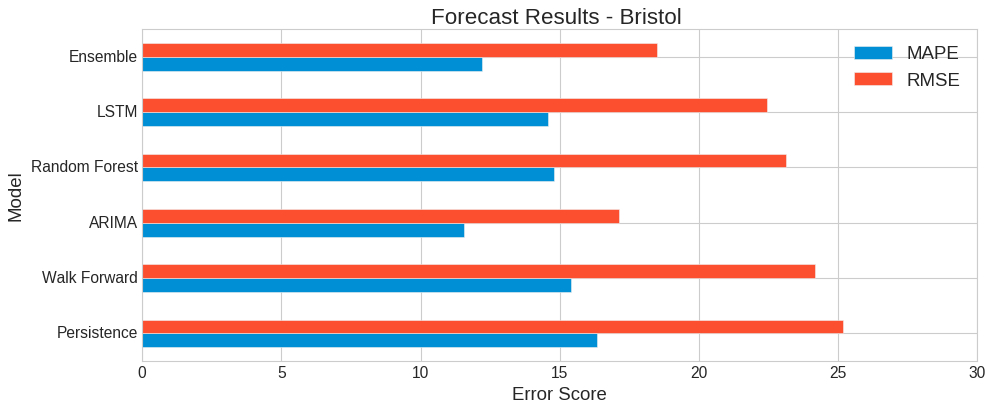

In [203]:
#comparing forecast results for all models
import matplotlib
matplotlib.rc('figure', figsize=(12, 5))
plt.style.use('seaborn-whitegrid')
overall_result.transpose().plot(kind='barh')
plt.title('Forecast Results - Bristol ')
plt.xlabel('Error Score')
plt.ylabel('Model')


The results suggest the following conclusions. The ARIMA model is the most accurate method for predicting daily occupancy for the Luton airport hotel. It shows the minimum error measurement (both MAPE and RMSE) amongst all the models and thereby, the highest model accuracy.